In [2]:
"""
KAGGLE NOTEBOOK: Flight Price Forecasting Model
Dataset: Expedia Flight Prices (itineraries.csv)
Goal: Predict ticket prices for different booking horizons
"""

# ============================================================================
# IMPORTS
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
from datetime import datetime, timedelta

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Optional: CatBoost (will check availability)
try:
    from catboost import CatBoostRegressor
    CATBOOST_AVAILABLE = True
    print("✓ CatBoost is available")
except ImportError:
    CATBOOST_AVAILABLE = False
    print("⚠ CatBoost not available, will use alternatives")

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# ============================================================================
# CONFIGURATION
# ============================================================================
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# File paths (Kaggle environment)
DATA_PATH = '/kaggle/input/flightprices/itineraries.csv'
PARQUET_PATH = '/kaggle/working/flight_data_sample.parquet'
MODEL_PATH = '/kaggle/working/ticket_price_forecaster_best.pkl'

# Sampling parameters
TARGET_SAMPLE_SIZE = 100_000  # Exactly 100k valid rows
CHUNK_SIZE = 50_000           # Read in chunks to manage memory

# Split parameters
TRAIN_TEST_SPLIT_RATIO = 0.8

# Model parameters
LOG_TRANSFORM = True  # Apply log1p to reduce price skew
EARLY_STOPPING_ROUNDS = 50
MAX_ITER = 1000

print(f"Configuration loaded successfully")
print(f"Random seed: {RANDOM_SEED}")
print(f"Target sample size: {TARGET_SAMPLE_SIZE:,} rows")
print(f"Data path: {DATA_PATH}")

✓ CatBoost is available
Configuration loaded successfully
Random seed: 42
Target sample size: 100,000 rows
Data path: /kaggle/input/flightprices/itineraries.csv


In [3]:
"""
STEP 1: Discover actual columns in the dataset
Read a small sample to understand structure before full processing
"""

print("="*80)
print("COLUMN DISCOVERY - Reading first 1000 rows to inspect structure")
print("="*80)

# Read small sample to discover columns
sample_df = pd.read_csv(DATA_PATH, nrows=1000)

print(f"\n📊 Dataset Shape (sample): {sample_df.shape}")
print(f"Rows: {sample_df.shape[0]:,}, Columns: {sample_df.shape[1]}")

print("\n" + "="*80)
print("AVAILABLE COLUMNS:")
print("="*80)
for i, col in enumerate(sample_df.columns, 1):
    print(f"{i:2d}. {col}")

print("\n" + "="*80)
print("DATA TYPES:")
print("="*80)
print(sample_df.dtypes)

print("\n" + "="*80)
print("FIRST 3 ROWS (PREVIEW):")
print("="*80)
print(sample_df.head(3).to_string())

print("\n" + "="*80)
print("MISSING VALUES SUMMARY:")
print("="*80)
missing_summary = pd.DataFrame({
    'Column': sample_df.columns,
    'Missing_Count': sample_df.isnull().sum().values,
    'Missing_Percent': (sample_df.isnull().sum().values / len(sample_df) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
if len(missing_summary) > 0:
    print(missing_summary.to_string(index=False))
else:
    print("✓ No missing values in sample")

print("\n" + "="*80)
print("COLUMN DETECTION COMPLETE")
print("="*80)

# Store column names for next step
all_columns = sample_df.columns.tolist()
print(f"\nTotal columns detected: {len(all_columns)}")

COLUMN DISCOVERY - Reading first 1000 rows to inspect structure

📊 Dataset Shape (sample): (1000, 27)
Rows: 1,000, Columns: 27

AVAILABLE COLUMNS:
 1. legId
 2. searchDate
 3. flightDate
 4. startingAirport
 5. destinationAirport
 6. fareBasisCode
 7. travelDuration
 8. elapsedDays
 9. isBasicEconomy
10. isRefundable
11. isNonStop
12. baseFare
13. totalFare
14. seatsRemaining
15. totalTravelDistance
16. segmentsDepartureTimeEpochSeconds
17. segmentsDepartureTimeRaw
18. segmentsArrivalTimeEpochSeconds
19. segmentsArrivalTimeRaw
20. segmentsArrivalAirportCode
21. segmentsDepartureAirportCode
22. segmentsAirlineName
23. segmentsAirlineCode
24. segmentsEquipmentDescription
25. segmentsDurationInSeconds
26. segmentsDistance
27. segmentsCabinCode

DATA TYPES:
legId                                 object
searchDate                            object
flightDate                            object
startingAirport                       object
destinationAirport                    object
fareBasisCo

In [4]:
"""
STEP 2: Read dataset in chunks, sample exactly 100K valid rows
Filter: non-null totalFare, valid dates
Save to parquet for fast reloading
"""

print("="*80)
print("CHUNKED READING - Sampling 100,000 valid rows")
print("="*80)

# Columns we definitely need (keep only useful ones to save memory)
COLUMNS_TO_KEEP = [
    'legId',
    'searchDate',
    'flightDate', 
    'startingAirport',
    'destinationAirport',
    'travelDuration',
    'elapsedDays',
    'isBasicEconomy',
    'isRefundable',
    'isNonStop',
    'baseFare',
    'totalFare',  # TARGET
    'seatsRemaining',
    'totalTravelDistance',
    'segmentsAirlineName',
    'segmentsAirlineCode',
    'segmentsCabinCode',
    'segmentsDurationInSeconds',
    'fareBasisCode'
]

print(f"Keeping {len(COLUMNS_TO_KEEP)} essential columns out of 27")
print(f"Target column: totalFare")

# Initialize collection
collected_rows = []
total_rows_read = 0
valid_rows_collected = 0
chunks_processed = 0

print(f"\nReading in chunks of {CHUNK_SIZE:,} rows...")
print("Filtering criteria:")
print("  - totalFare is not null")
print("  - totalFare > 0")
print("  - searchDate is not null")
print("  - flightDate is not null")

# Read in chunks
for chunk in pd.read_csv(DATA_PATH, chunksize=CHUNK_SIZE, usecols=COLUMNS_TO_KEEP):
    chunks_processed += 1
    total_rows_read += len(chunk)
    
    # Filter valid rows
    valid_chunk = chunk[
        chunk['totalFare'].notna() &
        (chunk['totalFare'] > 0) &
        chunk['searchDate'].notna() &
        chunk['flightDate'].notna()
    ].copy()
    
    if len(valid_chunk) > 0:
        collected_rows.append(valid_chunk)
        valid_rows_collected += len(valid_chunk)
    
    print(f"Chunk {chunks_processed}: Read {total_rows_read:,} total | "
          f"Valid so far: {valid_rows_collected:,} | "
          f"Target: {TARGET_SAMPLE_SIZE:,}", end='\r')
    
    # Stop when we have enough valid rows
    if valid_rows_collected >= TARGET_SAMPLE_SIZE:
        print()  # New line
        break

print(f"\n\n✓ Collected {valid_rows_collected:,} valid rows from {total_rows_read:,} total rows")

# Concatenate all chunks
df_collected = pd.concat(collected_rows, ignore_index=True)
print(f"Concatenated shape: {df_collected.shape}")

# Sample exactly 100K if we got more
if len(df_collected) > TARGET_SAMPLE_SIZE:
    print(f"Sampling exactly {TARGET_SAMPLE_SIZE:,} rows...")
    df_sample = df_collected.sample(n=TARGET_SAMPLE_SIZE, random_state=RANDOM_SEED).reset_index(drop=True)
else:
    df_sample = df_collected.copy()

print(f"\n✓ Final sample shape: {df_sample.shape}")

# Memory optimization - downcast numeric types
print("\n" + "="*80)
print("MEMORY OPTIMIZATION")
print("="*80)

memory_before = df_sample.memory_usage(deep=True).sum() / 1024**2

# Downcast floats
for col in df_sample.select_dtypes(include=['float64']).columns:
    df_sample[col] = pd.to_numeric(df_sample[col], downcast='float')

# Downcast integers
for col in df_sample.select_dtypes(include=['int64']).columns:
    df_sample[col] = pd.to_numeric(df_sample[col], downcast='integer')

memory_after = df_sample.memory_usage(deep=True).sum() / 1024**2
memory_saved = memory_before - memory_after

print(f"Memory before: {memory_before:.2f} MB")
print(f"Memory after: {memory_after:.2f} MB")
print(f"Memory saved: {memory_saved:.2f} MB ({memory_saved/memory_before*100:.1f}%)")

# Save to parquet for fast reload
print(f"\nSaving to parquet: {PARQUET_PATH}")
df_sample.to_parquet(PARQUET_PATH, index=False, compression='snappy')
parquet_size = Path(PARQUET_PATH).stat().st_size / 1024**2
print(f"✓ Saved successfully ({parquet_size:.2f} MB)")

# Summary statistics
print("\n" + "="*80)
print("SAMPLE SUMMARY")
print("="*80)
print(f"Shape: {df_sample.shape}")
print(f"\nColumns: {list(df_sample.columns)}")
print(f"\nData types:")
print(df_sample.dtypes)

print(f"\n" + "="*80)
print("Missing values in sample:")
print("="*80)
missing = df_sample.isnull().sum()
missing_pct = (missing / len(df_sample) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Missing_Percent': missing_pct
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
if len(missing_df) > 0:
    print(missing_df)
else:
    print("✓ No missing values")

print("\n" + "="*80)
print("✓ CHUNKED READING COMPLETE")
print("="*80)

CHUNKED READING - Sampling 100,000 valid rows
Keeping 19 essential columns out of 27
Target column: totalFare

Reading in chunks of 50,000 rows...
Filtering criteria:
  - totalFare is not null
  - totalFare > 0
  - searchDate is not null
  - flightDate is not null
Chunk 2: Read 100,000 total | Valid so far: 100,000 | Target: 100,000


✓ Collected 100,000 valid rows from 100,000 total rows
Concatenated shape: (100000, 19)

✓ Final sample shape: (100000, 19)

MEMORY OPTIMIZATION
Memory before: 66.84 MB
Memory after: 64.36 MB
Memory saved: 2.48 MB (3.7%)

Saving to parquet: /kaggle/working/flight_data_sample.parquet
✓ Saved successfully (4.29 MB)

SAMPLE SUMMARY
Shape: (100000, 19)

Columns: ['legId', 'searchDate', 'flightDate', 'startingAirport', 'destinationAirport', 'fareBasisCode', 'travelDuration', 'elapsedDays', 'isBasicEconomy', 'isRefundable', 'isNonStop', 'baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance', 'segmentsAirlineName', 'segmentsAirlineCode', 'segmentsDurat

LOADING DATA FROM PARQUET
✓ Loaded shape: (100000, 19)
Memory usage: 64.36 MB

FIRST 5 ROWS
                              legId  searchDate  flightDate startingAirport  \
0  9ca0e81111c683bec1012473feefd28f  2022-04-16  2022-04-17             ATL   
1  98685953630e772a098941b71906592b  2022-04-16  2022-04-17             ATL   
2  98d90cbc32bfbb05c2fc32897c7c1087  2022-04-16  2022-04-17             ATL   
3  969a269d38eae583f455486fa90877b4  2022-04-16  2022-04-17             ATL   
4  980370cf27c89b40d2833a1d5afc9751  2022-04-16  2022-04-17             ATL   

  destinationAirport fareBasisCode travelDuration  elapsedDays  \
0                BOS      LA0NX0MC        PT2H29M            0   
1                BOS      LA0NX0MC        PT2H30M            0   
2                BOS      LA0NX0MC        PT2H30M            0   
3                BOS      LA0NX0MC        PT2H32M            0   
4                BOS      LA0NX0MC        PT2H34M            0   

   isBasicEconomy  isRefundable  isN

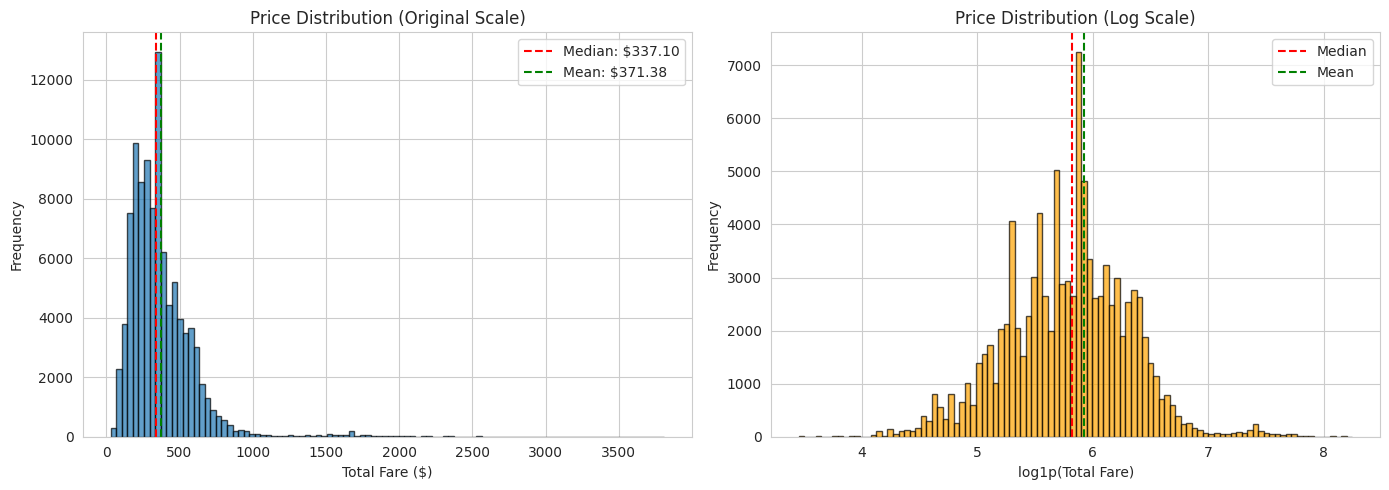


Price statistics:
  Min: $30.69
  Max: $3810.60
  Mean: $371.38
  Median: $337.10
  Std: $229.03
  Skewness: 3.33

TOP ROUTES (by frequency)
startingAirport  destinationAirport
ATL              LAX                   880
LGA              LAX                   828
ORD              LAX                   825
LAX              BOS                   819
                 ATL                   804
                 LGA                   800
CLT              LAX                   797
LAX              EWR                   787
LGA              ORD                   773
LAX              JFK                   754
dtype: int64

AIRLINES DISTRIBUTION
segmentsAirlineName
American Airlines||American Airlines    21591
United||United                          15486
Delta||Delta                            14975
American Airlines                        9186
Delta                                    6479
United                                   5871
Spirit Airlines||Spirit Airlines         4271
JetBlue Airway

In [5]:
"""
STEP 3: Reload parquet and perform exploratory analysis
"""

print("="*80)
print("LOADING DATA FROM PARQUET")
print("="*80)

# Reload from parquet (fast!)
df = pd.read_parquet(PARQUET_PATH)

print(f"✓ Loaded shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "="*80)
print("FIRST 5 ROWS")
print("="*80)
print(df.head())

print("\n" + "="*80)
print("TARGET VARIABLE: totalFare")
print("="*80)
print(df['totalFare'].describe())

# Visualize price distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original scale
axes[0].hist(df['totalFare'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Total Fare ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Price Distribution (Original Scale)')
axes[0].axvline(df['totalFare'].median(), color='red', linestyle='--', label=f'Median: ${df["totalFare"].median():.2f}')
axes[0].axvline(df['totalFare'].mean(), color='green', linestyle='--', label=f'Mean: ${df["totalFare"].mean():.2f}')
axes[0].legend()

# Log scale
axes[1].hist(np.log1p(df['totalFare']), bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('log1p(Total Fare)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Price Distribution (Log Scale)')
axes[1].axvline(np.log1p(df['totalFare'].median()), color='red', linestyle='--', label='Median')
axes[1].axvline(np.log1p(df['totalFare'].mean()), color='green', linestyle='--', label='Mean')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nPrice statistics:")
print(f"  Min: ${df['totalFare'].min():.2f}")
print(f"  Max: ${df['totalFare'].max():.2f}")
print(f"  Mean: ${df['totalFare'].mean():.2f}")
print(f"  Median: ${df['totalFare'].median():.2f}")
print(f"  Std: ${df['totalFare'].std():.2f}")
print(f"  Skewness: {df['totalFare'].skew():.2f}")

print("\n" + "="*80)
print("TOP ROUTES (by frequency)")
print("="*80)
route_counts = df.groupby(['startingAirport', 'destinationAirport']).size().sort_values(ascending=False).head(10)
print(route_counts)

print("\n" + "="*80)
print("AIRLINES DISTRIBUTION")
print("="*80)
airline_counts = df['segmentsAirlineName'].value_counts().head(10)
print(airline_counts)

print("\n" + "="*80)
print("FLIGHT CHARACTERISTICS")
print("="*80)
print(f"Non-stop flights: {df['isNonStop'].sum():,} ({df['isNonStop'].sum()/len(df)*100:.1f}%)")
print(f"Basic economy: {df['isBasicEconomy'].sum():,} ({df['isBasicEconomy'].sum()/len(df)*100:.1f}%)")
print(f"Refundable: {df['isRefundable'].sum():,} ({df['isRefundable'].sum()/len(df)*100:.1f}%)")

print("\n" + "="*80)
print("DATE RANGE CHECK (before parsing)")
print("="*80)
print(f"searchDate sample: {df['searchDate'].head(3).tolist()}")
print(f"flightDate sample: {df['flightDate'].head(3).tolist()}")

print("\n" + "="*80)
print("✓ EXPLORATORY ANALYSIS COMPLETE")
print("="*80)

In [6]:
"""
STEP 4: Feature Engineering
- Parse dates
- Calculate days_to_departure
- Extract temporal features (month, day of week, etc.)
- Parse duration if needed
"""

print("="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Create a copy to avoid modifying original
df_features = df.copy()

print("\n[1/6] Parsing searchDate and flightDate...")
# Parse dates
df_features['searchDate'] = pd.to_datetime(df_features['searchDate'], errors='coerce')
df_features['flightDate'] = pd.to_datetime(df_features['flightDate'], errors='coerce')

# Check for parsing failures
search_nulls = df_features['searchDate'].isnull().sum()
flight_nulls = df_features['flightDate'].isnull().sum()
print(f"  searchDate parsing failures: {search_nulls}")
print(f"  flightDate parsing failures: {flight_nulls}")

if search_nulls > 0 or flight_nulls > 0:
    print(f"  Removing {max(search_nulls, flight_nulls)} rows with invalid dates")
    df_features = df_features.dropna(subset=['searchDate', 'flightDate'])
    print(f"  New shape: {df_features.shape}")

print(f"✓ Date range:")
print(f"  searchDate: {df_features['searchDate'].min()} to {df_features['searchDate'].max()}")
print(f"  flightDate: {df_features['flightDate'].min()} to {df_features['flightDate'].max()}")

print("\n[2/6] Calculating days_to_departure (booking horizon)...")
# Critical feature: days from search to flight
df_features['days_to_departure'] = (df_features['flightDate'] - df_features['searchDate']).dt.days

# Remove invalid booking horizons
invalid_horizon = (df_features['days_to_departure'] < 0) | (df_features['days_to_departure'] > 365)
print(f"  Rows with invalid horizon (negative or >365 days): {invalid_horizon.sum()}")
if invalid_horizon.sum() > 0:
    df_features = df_features[~invalid_horizon]
    print(f"  Removed. New shape: {df_features.shape}")

print(f"✓ days_to_departure statistics:")
print(df_features['days_to_departure'].describe())

print("\n[3/6] Extracting temporal features from searchDate...")
df_features['search_month'] = df_features['searchDate'].dt.month
df_features['search_day_of_week'] = df_features['searchDate'].dt.dayofweek  # 0=Monday
df_features['search_day_of_month'] = df_features['searchDate'].dt.day
df_features['search_is_weekend'] = df_features['search_day_of_week'].isin([5, 6]).astype(int)

print(f"✓ Created: search_month, search_day_of_week, search_day_of_month, search_is_weekend")

print("\n[4/6] Extracting temporal features from flightDate...")
df_features['flight_month'] = df_features['flightDate'].dt.month
df_features['flight_day_of_week'] = df_features['flightDate'].dt.dayofweek
df_features['flight_day_of_month'] = df_features['flightDate'].dt.day
df_features['flight_is_weekend'] = df_features['flight_day_of_week'].isin([5, 6]).astype(int)

print(f"✓ Created: flight_month, flight_day_of_week, flight_day_of_month, flight_is_weekend")

print("\n[5/6] Creating route feature...")
df_features['route'] = df_features['startingAirport'] + '_' + df_features['destinationAirport']
print(f"✓ Created: route (combined origin-destination)")
print(f"  Unique routes: {df_features['route'].nunique()}")

print("\n[6/6] Parsing travelDuration (ISO 8601 format)...")
# Parse ISO duration like 'PT2H29M' -> minutes
def parse_duration(duration_str):
    """Parse ISO 8601 duration to minutes"""
    if pd.isnull(duration_str) or duration_str == '':
        return np.nan
    try:
        # Remove 'PT' prefix
        duration_str = str(duration_str).replace('PT', '')
        hours = 0
        minutes = 0
        
        if 'H' in duration_str:
            h_split = duration_str.split('H')
            hours = int(h_split[0])
            duration_str = h_split[1] if len(h_split) > 1 else ''
        
        if 'M' in duration_str:
            minutes = int(duration_str.replace('M', ''))
        
        return hours * 60 + minutes
    except:
        return np.nan

df_features['duration_minutes'] = df_features['travelDuration'].apply(parse_duration)
print(f"  Duration parsing successful: {df_features['duration_minutes'].notna().sum():,} rows")
print(f"  Duration statistics (minutes):")
print(df_features['duration_minutes'].describe())

# Fill missing durations with median
if df_features['duration_minutes'].isnull().sum() > 0:
    median_duration = df_features['duration_minutes'].median()
    df_features['duration_minutes'].fillna(median_duration, inplace=True)
    print(f"  Filled {df_features['duration_minutes'].isnull().sum()} missing values with median: {median_duration:.0f} min")

print("\n" + "="*80)
print("FEATURE SUMMARY")
print("="*80)
print(f"Final shape: {df_features.shape}")
print(f"\nNew features created:")
new_features = ['days_to_departure', 'search_month', 'search_day_of_week', 'search_day_of_month',
                'search_is_weekend', 'flight_month', 'flight_day_of_week', 'flight_day_of_month',
                'flight_is_weekend', 'route', 'duration_minutes']
for feat in new_features:
    print(f"  ✓ {feat}")

print(f"\nData types after feature engineering:")
print(df_features.dtypes)

print("\n" + "="*80)
print("MISSING VALUES CHECK")
print("="*80)
missing = df_features.isnull().sum()
missing_pct = (missing / len(df_features) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Missing_Percent': missing_pct
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
if len(missing_df) > 0:
    print(missing_df)
else:
    print("✓ No missing values")

print("\n" + "="*80)
print("✓ FEATURE ENGINEERING COMPLETE")
print("="*80)

# Save the engineered dataset for next step
df = df_features.copy()
print(f"\n✓ Updated df with {len(df):,} rows ready for modeling")

FEATURE ENGINEERING

[1/6] Parsing searchDate and flightDate...
  searchDate parsing failures: 0
  flightDate parsing failures: 0
✓ Date range:
  searchDate: 2022-04-16 00:00:00 to 2022-04-17 00:00:00
  flightDate: 2022-04-17 00:00:00 to 2022-04-26 00:00:00

[2/6] Calculating days_to_departure (booking horizon)...
  Rows with invalid horizon (negative or >365 days): 0
✓ days_to_departure statistics:
count    100000.000000
mean          4.964620
std           3.041302
min           1.000000
25%           2.000000
50%           5.000000
75%           8.000000
max          10.000000
Name: days_to_departure, dtype: float64

[3/6] Extracting temporal features from searchDate...
✓ Created: search_month, search_day_of_week, search_day_of_month, search_is_weekend

[4/6] Extracting temporal features from flightDate...
✓ Created: flight_month, flight_day_of_week, flight_day_of_month, flight_is_weekend

[5/6] Creating route feature...
✓ Created: route (combined origin-destination)
  Unique routes

In [7]:
"""
STEP 5: Train/Test Split - Time-based to avoid data leakage
Split by searchDate: earlier dates = train, later dates = test
"""

print("="*80)
print("TRAIN/TEST SPLIT (Time-Based)")
print("="*80)

# Sort by searchDate to ensure chronological ordering
df_sorted = df.sort_values('searchDate').reset_index(drop=True)

print(f"Total rows: {len(df_sorted):,}")
print(f"Date range: {df_sorted['searchDate'].min()} to {df_sorted['searchDate'].max()}")

# Calculate split index (80/20)
split_idx = int(len(df_sorted) * TRAIN_TEST_SPLIT_RATIO)

# Split
train_df = df_sorted.iloc[:split_idx].copy()
test_df = df_sorted.iloc[split_idx:].copy()

print(f"\n✓ Split at index {split_idx:,}")
print(f"Train size: {len(train_df):,} rows ({len(train_df)/len(df_sorted)*100:.1f}%)")
print(f"Test size: {len(test_df):,} rows ({len(test_df)/len(df_sorted)*100:.1f}%)")

print("\n" + "="*80)
print("TRAIN SET")
print("="*80)
print(f"searchDate range: {train_df['searchDate'].min()} to {train_df['searchDate'].max()}")
print(f"flightDate range: {train_df['flightDate'].min()} to {train_df['flightDate'].max()}")
print(f"Price stats:")
print(train_df['totalFare'].describe())

print("\n" + "="*80)
print("TEST SET")
print("="*80)
print(f"searchDate range: {test_df['searchDate'].min()} to {test_df['searchDate'].max()}")
print(f"flightDate range: {test_df['flightDate'].min()} to {test_df['flightDate'].max()}")
print(f"Price stats:")
print(test_df['totalFare'].describe())

# Verify no temporal leakage
print("\n" + "="*80)
print("TEMPORAL LEAKAGE CHECK")
print("="*80)
max_train_date = train_df['searchDate'].max()
min_test_date = test_df['searchDate'].min()
print(f"Latest searchDate in train: {max_train_date}")
print(f"Earliest searchDate in test: {min_test_date}")
if max_train_date < min_test_date:
    print("✓ No temporal leakage - train dates < test dates")
else:
    print("⚠ WARNING: Potential temporal overlap")

# Define feature columns for modeling
print("\n" + "="*80)
print("FEATURE SELECTION FOR MODELING")
print("="*80)

# Categorical features
categorical_features = [
    'startingAirport',
    'destinationAirport',
    'route',
    'segmentsAirlineName',
    'segmentsCabinCode'
]

# Numerical features
numerical_features = [
    'days_to_departure',
    'duration_minutes',
    'search_month',
    'search_day_of_week',
    'flight_month',
    'flight_day_of_week',
    'elapsedDays',
    'seatsRemaining',
    'totalTravelDistance'
]

# Boolean features (will be treated as numerical)
boolean_features = [
    'isBasicEconomy',
    'isRefundable',
    'isNonStop',
    'search_is_weekend',
    'flight_is_weekend'
]

# Combine all feature columns
all_features = categorical_features + numerical_features + boolean_features

print(f"Categorical features ({len(categorical_features)}):")
for feat in categorical_features:
    print(f"  - {feat}")

print(f"\nNumerical features ({len(numerical_features)}):")
for feat in numerical_features:
    print(f"  - {feat}")

print(f"\nBoolean features ({len(boolean_features)}):")
for feat in boolean_features:
    print(f"  - {feat}")

print(f"\n✓ Total features: {len(all_features)}")

# Target variable
target = 'totalFare'
print(f"✓ Target: {target}")

# Prepare X and y for train/test
print("\n" + "="*80)
print("PREPARING FEATURE MATRICES")
print("="*80)

# Handle missing values in totalTravelDistance
print(f"Filling missing totalTravelDistance with median...")
median_distance = train_df['totalTravelDistance'].median()
train_df['totalTravelDistance'].fillna(median_distance, inplace=True)
test_df['totalTravelDistance'].fillna(median_distance, inplace=True)
print(f"✓ Median distance: {median_distance:.2f}")

# Create feature matrices
X_train = train_df[all_features].copy()
y_train = train_df[target].copy()

X_test = test_df[all_features].copy()
y_test = test_df[target].copy()

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Apply log transform to target
print(f"\n" + "="*80)
print("TARGET TRANSFORMATION")
print("="*80)
print(f"Applying log1p transform to reduce skewness...")
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

print(f"✓ Original y_train - mean: ${y_train.mean():.2f}, std: ${y_train.std():.2f}, skew: {y_train.skew():.2f}")
print(f"✓ Log-transformed y_train - mean: {y_train_log.mean():.2f}, std: {y_train_log.std():.2f}, skew: {y_train_log.skew():.2f}")

print("\n" + "="*80)
print("✓ TRAIN/TEST SPLIT COMPLETE")
print("="*80)

TRAIN/TEST SPLIT (Time-Based)
Total rows: 100,000
Date range: 2022-04-16 00:00:00 to 2022-04-17 00:00:00

✓ Split at index 80,000
Train size: 80,000 rows (80.0%)
Test size: 20,000 rows (20.0%)

TRAIN SET
searchDate range: 2022-04-16 00:00:00 to 2022-04-16 00:00:00
flightDate range: 2022-04-17 00:00:00 to 2022-04-26 00:00:00
Price stats:
count    80000.000000
mean       375.421295
std        236.437973
min         30.690001
25%        227.600006
50%        338.600006
75%        467.600006
max       3810.600098
Name: totalFare, dtype: float64

TEST SET
searchDate range: 2022-04-16 00:00:00 to 2022-04-17 00:00:00
flightDate range: 2022-04-18 00:00:00 to 2022-04-20 00:00:00
Price stats:
count    20000.000000
mean       355.196686
std        195.816605
min         65.989998
25%        237.100006
50%        322.600006
75%        423.609985
max       3810.600098
Name: totalFare, dtype: float64

TEMPORAL LEAKAGE CHECK
Latest searchDate in train: 2022-04-16 00:00:00
Earliest searchDate in test:

MODEL A: CatBoostRegressor
Categorical feature indices: [0, 1, 2, 3, 4]
Categorical features: ['startingAirport', 'destinationAirport', 'route', 'segmentsAirlineName', 'segmentsCabinCode']

Creating CatBoost Pool datasets...
✓ Pools created

TRAINING CatBoost...
0:	learn: 0.5328058	test: 0.4511764	best: 0.4511764 (0)	total: 113ms	remaining: 1m 52s
100:	learn: 0.2995109	test: 0.2838948	best: 0.2838948 (100)	total: 3.47s	remaining: 30.9s
200:	learn: 0.2748365	test: 0.2583793	best: 0.2583793 (200)	total: 7.02s	remaining: 27.9s
300:	learn: 0.2613311	test: 0.2464587	best: 0.2464587 (300)	total: 10.9s	remaining: 25.3s
400:	learn: 0.2528941	test: 0.2392837	best: 0.2392837 (400)	total: 14.7s	remaining: 22s
500:	learn: 0.2459895	test: 0.2335497	best: 0.2335497 (500)	total: 18.5s	remaining: 18.4s
600:	learn: 0.2405701	test: 0.2287761	best: 0.2287761 (600)	total: 22.3s	remaining: 14.8s
700:	learn: 0.2363953	test: 0.2253504	best: 0.2253504 (700)	total: 26s	remaining: 11.1s
800:	learn: 0.2328993	te

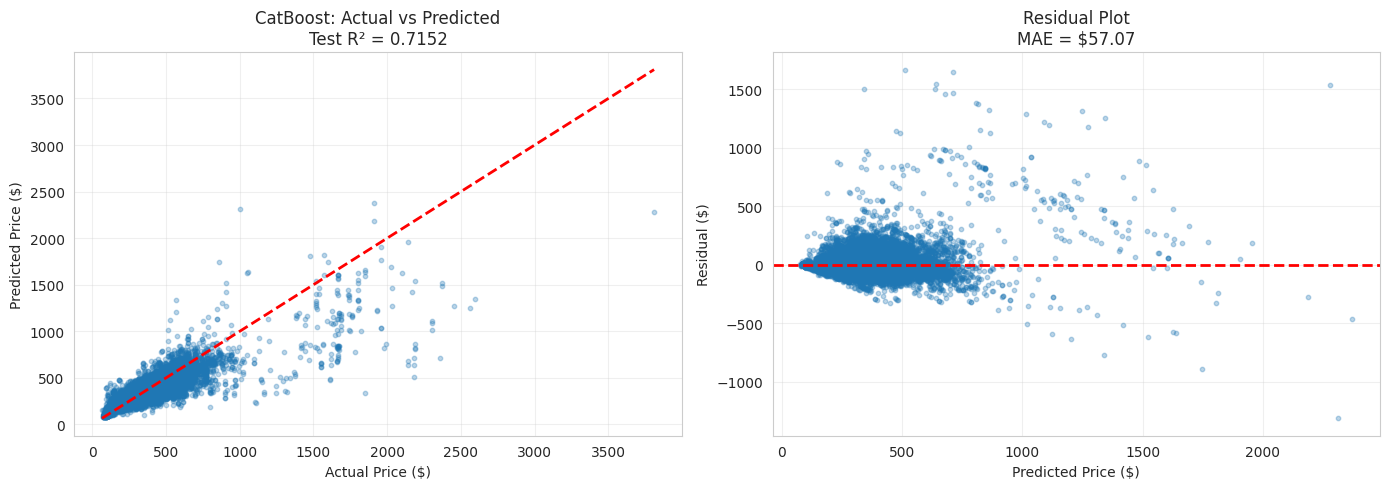


✓ MODEL A (CatBoost) COMPLETE

✓ Results stored for model comparison


In [8]:
"""
STEP 6: Train CatBoost Model
CatBoost handles categorical features natively - no need for one-hot encoding
"""

print("="*80)
print("MODEL A: CatBoostRegressor")
print("="*80)

from catboost import CatBoostRegressor, Pool

# Identify categorical feature indices
cat_feature_indices = [all_features.index(feat) for feat in categorical_features]
print(f"Categorical feature indices: {cat_feature_indices}")
print(f"Categorical features: {categorical_features}")

# Create CatBoost datasets
print("\nCreating CatBoost Pool datasets...")
train_pool = Pool(
    data=X_train,
    label=y_train_log,
    cat_features=cat_feature_indices
)

test_pool = Pool(
    data=X_test,
    label=y_test_log,
    cat_features=cat_feature_indices
)
print("✓ Pools created")

# Initialize CatBoost model
print("\n" + "="*80)
print("TRAINING CatBoost...")
print("="*80)

catboost_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=RANDOM_SEED,
    verbose=100,
    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
    use_best_model=True,
    task_type='CPU'
)

# Train with validation monitoring
catboost_model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=100,
    plot=False
)

print("\n✓ Training complete!")
print(f"Best iteration: {catboost_model.best_iteration_}")
print(f"Best score: {catboost_model.best_score_}")

# Predictions in log space
print("\n" + "="*80)
print("GENERATING PREDICTIONS")
print("="*80)

y_train_pred_log = catboost_model.predict(X_train)
y_test_pred_log = catboost_model.predict(X_test)

# Transform back to original price scale
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)

print("✓ Predictions generated and transformed back to original scale")

# Evaluate on ORIGINAL price scale
print("\n" + "="*80)
print("EVALUATION METRICS (Original Price Scale)")
print("="*80)

# Train metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

print("TRAIN SET:")
print(f"  MAE:  ${train_mae:.2f}")
print(f"  RMSE: ${train_rmse:.2f}")
print(f"  R²:   {train_r2:.4f}")

# Test metrics
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("\nTEST SET:")
print(f"  MAE:  ${test_mae:.2f}")
print(f"  RMSE: ${test_rmse:.2f}")
print(f"  R²:   {test_r2:.4f}")

# Calculate percentage error
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f"  MAPE: {test_mape:.2f}%")

# Feature importance
print("\n" + "="*80)
print("TOP 10 FEATURE IMPORTANCES")
print("="*80)

feature_importance = catboost_model.get_feature_importance()
importance_df = pd.DataFrame({
    'feature': all_features,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(importance_df.head(10).to_string(index=False))

# Visualize predictions
print("\n" + "="*80)
print("VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
axes[0].scatter(y_test, y_test_pred, alpha=0.3, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title(f'CatBoost: Actual vs Predicted\nTest R² = {test_r2:.4f}')
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.3, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price ($)')
axes[1].set_ylabel('Residual ($)')
axes[1].set_title(f'Residual Plot\nMAE = ${test_mae:.2f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ MODEL A (CatBoost) COMPLETE")
print("="*80)

# Store results for comparison
catboost_results = {
    'model_name': 'CatBoost',
    'train_mae': train_mae,
    'train_rmse': train_rmse,
    'train_r2': train_r2,
    'test_mae': test_mae,
    'test_rmse': test_rmse,
    'test_r2': test_r2,
    'test_mape': test_mape,
    'model_object': catboost_model
}

print(f"\n✓ Results stored for model comparison")

MODEL B: HistGradientBoostingRegressor
Creating preprocessing pipeline...
Categorical features: ['startingAirport', 'destinationAirport', 'route', 'segmentsAirlineName', 'segmentsCabinCode']
Numerical + Boolean features: ['days_to_departure', 'duration_minutes', 'search_month', 'search_day_of_week', 'flight_month', 'flight_day_of_week', 'elapsedDays', 'seatsRemaining', 'totalTravelDistance', 'isBasicEconomy', 'isRefundable', 'isNonStop', 'search_is_weekend', 'flight_is_weekend']
✓ Preprocessor created with OneHotEncoder (sparse_output=False for dense arrays)

Fitting preprocessor on training data...
✓ X_train_processed shape: (80000, 388)
✓ X_test_processed shape: (20000, 388)
  Features expanded from 19 to 388 after one-hot encoding

TRAINING HistGradientBoosting...
Binning 0.223 GB of training data: 0.480 s
Binning 0.025 GB of validation data: 0.022 s
Fitting gradient boosted rounds:
Fit 1000 trees in 71.867 s, (29037 total leaves)
Time spent computing histograms: 65.828s
Time spent 

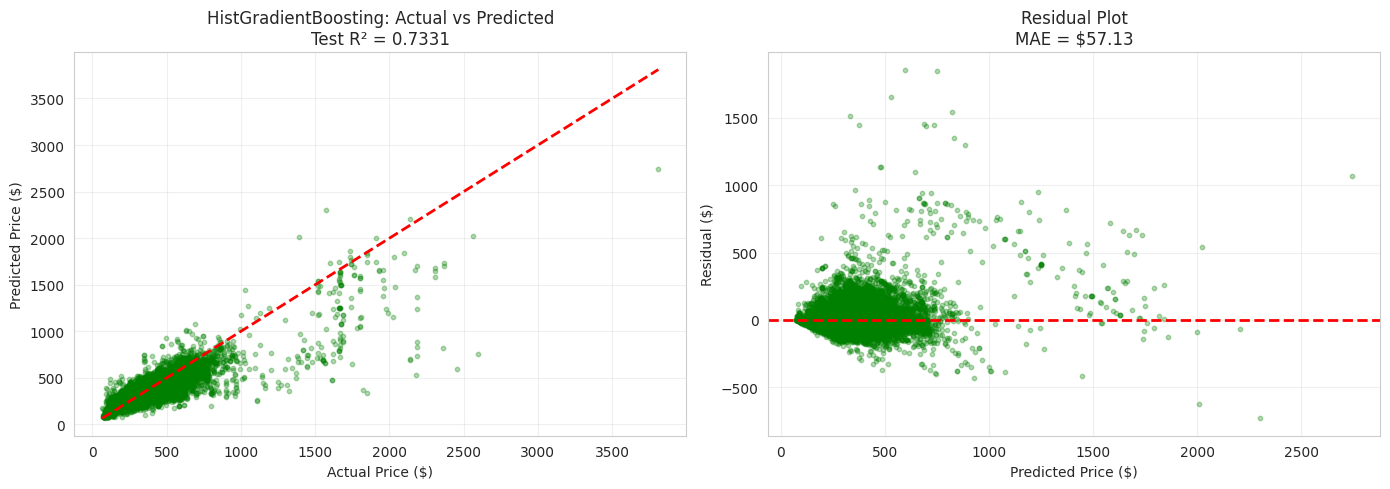


✓ MODEL B (HistGradientBoosting) COMPLETE

✓ Results stored for model comparison


In [9]:
"""
STEP 7: Train HistGradientBoosting Model (sklearn alternative)
Requires one-hot encoding for categorical features
"""

print("="*80)
print("MODEL B: HistGradientBoostingRegressor")
print("="*80)

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Create preprocessing pipeline
print("Creating preprocessing pipeline...")
print(f"Categorical features: {categorical_features}")
print(f"Numerical + Boolean features: {numerical_features + boolean_features}")

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), 
         categorical_features),
        ('num', 'passthrough', numerical_features + boolean_features)
    ],
    verbose_feature_names_out=False
)

print("✓ Preprocessor created with OneHotEncoder (sparse_output=False for dense arrays)")

# Fit preprocessor on training data
print("\nFitting preprocessor on training data...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"✓ X_train_processed shape: {X_train_processed.shape}")
print(f"✓ X_test_processed shape: {X_test_processed.shape}")
print(f"  Features expanded from {X_train.shape[1]} to {X_train_processed.shape[1]} after one-hot encoding")

# Initialize HistGradientBoosting model
print("\n" + "="*80)
print("TRAINING HistGradientBoosting...")
print("="*80)

histgb_model = HistGradientBoostingRegressor(
    max_iter=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=RANDOM_SEED,
    early_stopping=True,
    n_iter_no_change=EARLY_STOPPING_ROUNDS,
    validation_fraction=0.1,
    verbose=1
)

# Train
import time
start_time = time.time()

histgb_model.fit(X_train_processed, y_train_log)

train_time = time.time() - start_time

print(f"\n✓ Training complete in {train_time:.1f} seconds")
print(f"Best iteration: {histgb_model.n_iter_}")

# Predictions
print("\n" + "="*80)
print("GENERATING PREDICTIONS")
print("="*80)

y_train_pred_log_hgb = histgb_model.predict(X_train_processed)
y_test_pred_log_hgb = histgb_model.predict(X_test_processed)

# Transform back to original price scale
y_train_pred_hgb = np.expm1(y_train_pred_log_hgb)
y_test_pred_hgb = np.expm1(y_test_pred_log_hgb)

print("✓ Predictions generated and transformed back to original scale")

# Evaluate
print("\n" + "="*80)
print("EVALUATION METRICS (Original Price Scale)")
print("="*80)

# Train metrics
train_mae_hgb = mean_absolute_error(y_train, y_train_pred_hgb)
train_rmse_hgb = np.sqrt(mean_squared_error(y_train, y_train_pred_hgb))
train_r2_hgb = r2_score(y_train, y_train_pred_hgb)

print("TRAIN SET:")
print(f"  MAE:  ${train_mae_hgb:.2f}")
print(f"  RMSE: ${train_rmse_hgb:.2f}")
print(f"  R²:   {train_r2_hgb:.4f}")

# Test metrics
test_mae_hgb = mean_absolute_error(y_test, y_test_pred_hgb)
test_rmse_hgb = np.sqrt(mean_squared_error(y_test, y_test_pred_hgb))
test_r2_hgb = r2_score(y_test, y_test_pred_hgb)

print("\nTEST SET:")
print(f"  MAE:  ${test_mae_hgb:.2f}")
print(f"  RMSE: ${test_rmse_hgb:.2f}")
print(f"  R²:   {test_r2_hgb:.4f}")

test_mape_hgb = np.mean(np.abs((y_test - y_test_pred_hgb) / y_test)) * 100
print(f"  MAPE: {test_mape_hgb:.2f}%")

# Visualization
print("\n" + "="*80)
print("VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
axes[0].scatter(y_test, y_test_pred_hgb, alpha=0.3, s=10, color='green')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title(f'HistGradientBoosting: Actual vs Predicted\nTest R² = {test_r2_hgb:.4f}')
axes[0].grid(True, alpha=0.3)

# Residuals
residuals_hgb = y_test - y_test_pred_hgb
axes[1].scatter(y_test_pred_hgb, residuals_hgb, alpha=0.3, s=10, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price ($)')
axes[1].set_ylabel('Residual ($)')
axes[1].set_title(f'Residual Plot\nMAE = ${test_mae_hgb:.2f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ MODEL B (HistGradientBoosting) COMPLETE")
print("="*80)

# Store results
histgb_results = {
    'model_name': 'HistGradientBoosting',
    'train_mae': train_mae_hgb,
    'train_rmse': train_rmse_hgb,
    'train_r2': train_r2_hgb,
    'test_mae': test_mae_hgb,
    'test_rmse': test_rmse_hgb,
    'test_r2': test_r2_hgb,
    'test_mape': test_mape_hgb,
    'model_object': histgb_model,
    'preprocessor': preprocessor
}

print(f"\n✓ Results stored for model comparison")

MODEL C: Ridge Regression (Baseline)
Using preprocessed features from HistGradientBoosting pipeline
X_train_processed shape: (80000, 388)
X_test_processed shape: (20000, 388)

Scaling features with StandardScaler...
✓ Features scaled

TRAINING Ridge Regression...
✓ Training complete in 0.545 seconds

GENERATING PREDICTIONS
✓ Predictions generated and transformed back to original scale

EVALUATION METRICS (Original Price Scale)
TRAIN SET:
  MAE:  $94.28
  RMSE: $158.28
  R²:   0.5519

TEST SET:
  MAE:  $85.47
  RMSE: $141.74
  R²:   0.4760
  MAPE: 24.57%

VISUALIZATION


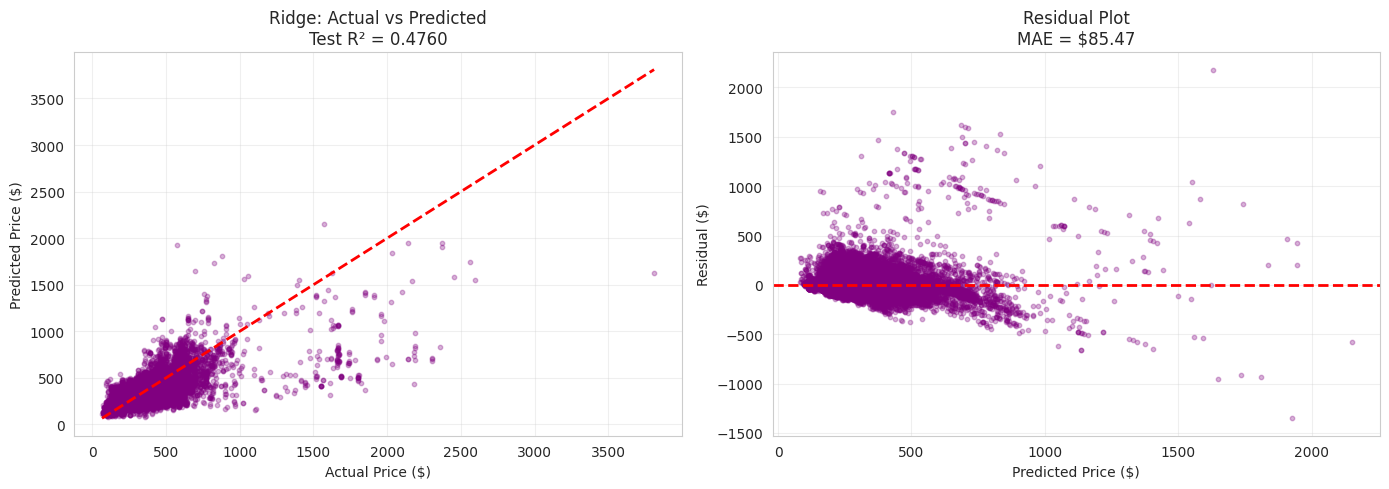


✓ MODEL C (Ridge) COMPLETE

✓ Results stored for model comparison


In [10]:
"""
STEP 8: Train Ridge Regression (Simple Baseline)
Should perform worse but validates our feature engineering
"""

print("="*80)
print("MODEL C: Ridge Regression (Baseline)")
print("="*80)

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Use same preprocessed data from HistGradientBoosting
print("Using preprocessed features from HistGradientBoosting pipeline")
print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"X_test_processed shape: {X_test_processed.shape}")

# Scale features for Ridge (important for linear models)
print("\nScaling features with StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)
print("✓ Features scaled")

# Initialize Ridge model
print("\n" + "="*80)
print("TRAINING Ridge Regression...")
print("="*80)

ridge_model = Ridge(
    alpha=10.0,  # Regularization strength
    random_state=RANDOM_SEED,
    max_iter=1000
)

# Train
import time
start_time = time.time()

ridge_model.fit(X_train_scaled, y_train_log)

train_time = time.time() - start_time

print(f"✓ Training complete in {train_time:.3f} seconds")

# Predictions
print("\n" + "="*80)
print("GENERATING PREDICTIONS")
print("="*80)

y_train_pred_log_ridge = ridge_model.predict(X_train_scaled)
y_test_pred_log_ridge = ridge_model.predict(X_test_scaled)

# Transform back to original price scale
y_train_pred_ridge = np.expm1(y_train_pred_log_ridge)
y_test_pred_ridge = np.expm1(y_test_pred_log_ridge)

print("✓ Predictions generated and transformed back to original scale")

# Evaluate
print("\n" + "="*80)
print("EVALUATION METRICS (Original Price Scale)")
print("="*80)

# Train metrics
train_mae_ridge = mean_absolute_error(y_train, y_train_pred_ridge)
train_rmse_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
train_r2_ridge = r2_score(y_train, y_train_pred_ridge)

print("TRAIN SET:")
print(f"  MAE:  ${train_mae_ridge:.2f}")
print(f"  RMSE: ${train_rmse_ridge:.2f}")
print(f"  R²:   {train_r2_ridge:.4f}")

# Test metrics
test_mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
test_rmse_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))
test_r2_ridge = r2_score(y_test, y_test_pred_ridge)

print("\nTEST SET:")
print(f"  MAE:  ${test_mae_ridge:.2f}")
print(f"  RMSE: ${test_rmse_ridge:.2f}")
print(f"  R²:   {test_r2_ridge:.4f}")

test_mape_ridge = np.mean(np.abs((y_test - y_test_pred_ridge) / y_test)) * 100
print(f"  MAPE: {test_mape_ridge:.2f}%")

# Visualization
print("\n" + "="*80)
print("VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
axes[0].scatter(y_test, y_test_pred_ridge, alpha=0.3, s=10, color='purple')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title(f'Ridge: Actual vs Predicted\nTest R² = {test_r2_ridge:.4f}')
axes[0].grid(True, alpha=0.3)

# Residuals
residuals_ridge = y_test - y_test_pred_ridge
axes[1].scatter(y_test_pred_ridge, residuals_ridge, alpha=0.3, s=10, color='purple')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price ($)')
axes[1].set_ylabel('Residual ($)')
axes[1].set_title(f'Residual Plot\nMAE = ${test_mae_ridge:.2f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ MODEL C (Ridge) COMPLETE")
print("="*80)

# Store results
ridge_results = {
    'model_name': 'Ridge',
    'train_mae': train_mae_ridge,
    'train_rmse': train_rmse_ridge,
    'train_r2': train_r2_ridge,
    'test_mae': test_mae_ridge,
    'test_rmse': test_rmse_ridge,
    'test_r2': test_r2_ridge,
    'test_mape': test_mape_ridge,
    'model_object': ridge_model,
    'scaler': scaler
}

print(f"\n✓ Results stored for model comparison")

In [11]:
"""
Quick Ridge baseline - expect worse performance
"""

print("="*80)
print("MODEL C: Ridge Regression (Baseline)")
print("="*80)

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

print("Using preprocessed features from HistGradientBoosting")
print(f"Shape: {X_train_processed.shape}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)

# Train Ridge
ridge_model = Ridge(alpha=10.0, random_state=RANDOM_SEED)
ridge_model.fit(X_train_scaled, y_train_log)

# Predict
y_test_pred_log_ridge = ridge_model.predict(X_test_scaled)
y_test_pred_ridge = np.expm1(y_test_pred_log_ridge)

# Metrics
test_mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
test_rmse_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))
test_r2_ridge = r2_score(y_test, y_test_pred_ridge)

print(f"\nTEST METRICS:")
print(f"  MAE:  ${test_mae_ridge:.2f}")
print(f"  RMSE: ${test_rmse_ridge:.2f}")
print(f"  R²:   {test_r2_ridge:.4f}")

ridge_results = {
    'model_name': 'Ridge',
    'test_mae': test_mae_ridge,
    'test_rmse': test_rmse_ridge,
    'test_r2': test_r2_ridge,
    'model_object': ridge_model,
    'scaler': scaler
}

print("✓ Ridge complete")

MODEL C: Ridge Regression (Baseline)
Using preprocessed features from HistGradientBoosting
Shape: (80000, 388)

TEST METRICS:
  MAE:  $85.47
  RMSE: $141.74
  R²:   0.4760
✓ Ridge complete


In [12]:
"""
Compare all 3 models and select the best
"""

print("="*80)
print("MODEL COMPARISON LEADERBOARD")
print("="*80)

# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Model': 'CatBoost',
        'Test_MAE': catboost_results['test_mae'],
        'Test_RMSE': catboost_results['test_rmse'],
        'Test_R2': catboost_results['test_r2'],
        'Test_MAPE': catboost_results['test_mape']
    },
    {
        'Model': 'HistGradientBoosting',
        'Test_MAE': histgb_results['test_mae'],
        'Test_RMSE': histgb_results['test_rmse'],
        'Test_R2': histgb_results['test_r2'],
        'Test_MAPE': histgb_results['test_mape']
    },
    {
        'Model': 'Ridge',
        'Test_MAE': ridge_results['test_mae'],
        'Test_RMSE': ridge_results['test_rmse'],
        'Test_R2': ridge_results['test_r2'],
        'Test_MAPE': np.nan
    }
])

# Sort by MAE (lower is better)
comparison_df = comparison_df.sort_values('Test_MAE')

print(comparison_df.to_string(index=False))

# Select best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\n{'='*80}")
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"{'='*80}")

# Get best model object and preprocessor
if best_model_name == 'CatBoost':
    best_model = catboost_results['model_object']
    best_preprocessor = None  # CatBoost doesn't need preprocessing
    best_scaler = None
elif best_model_name == 'HistGradientBoosting':
    best_model = histgb_results['model_object']
    best_preprocessor = histgb_results['preprocessor']
    best_scaler = None
else:
    best_model = ridge_results['model_object']
    best_preprocessor = histgb_results['preprocessor']
    best_scaler = ridge_results['scaler']

print(f"Selected: {best_model_name}")
print(f"Test MAE: ${comparison_df.iloc[0]['Test_MAE']:.2f}")
print(f"Test R²: {comparison_df.iloc[0]['Test_R2']:.4f}")

MODEL COMPARISON LEADERBOARD
               Model  Test_MAE  Test_RMSE  Test_R2  Test_MAPE
            CatBoost 57.072986 104.505397 0.715155  16.071149
HistGradientBoosting 57.125084 101.162065 0.733089  16.151324
               Ridge 85.466521 141.741674 0.476006        NaN

🏆 BEST MODEL: CatBoost
Selected: CatBoost
Test MAE: $57.07
Test R²: 0.7152


In [13]:
"""
Save complete artifact with model + metadata
"""

print("="*80)
print("SAVING MODEL ARTIFACT")
print("="*80)

# Create comprehensive artifact
model_artifact = {
    # Model components
    'model': best_model,
    'preprocessor': best_preprocessor,
    'scaler': best_scaler,
    'model_name': best_model_name,
    
    # Features
    'feature_columns': all_features,
    'categorical_features': categorical_features,
    'numerical_features': numerical_features,
    'boolean_features': boolean_features,
    
    # Target
    'target_column': 'totalFare',
    'log_transform': LOG_TRANSFORM,
    
    # Metadata
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_path': DATA_PATH,
    'sample_size': len(df),
    'test_metrics': {
        'mae': comparison_df.iloc[0]['Test_MAE'],
        'rmse': comparison_df.iloc[0]['Test_RMSE'],
        'r2': comparison_df.iloc[0]['Test_R2']
    },
    
    # Data statistics for validation
    'price_stats': {
        'min': float(y_train.min()),
        'max': float(y_train.max()),
        'mean': float(y_train.mean()),
        'median': float(y_train.median())
    }
}

# Save to disk
joblib.dump(model_artifact, MODEL_PATH, compress=3)

file_size = Path(MODEL_PATH).stat().st_size / 1024**2
print(f"✓ Model saved to: {MODEL_PATH}")
print(f"  File size: {file_size:.2f} MB")

# Verify by loading
print("\nVerifying artifact...")
loaded_artifact = joblib.load(MODEL_PATH)
print(f"✓ Artifact loaded successfully")
print(f"  Model: {loaded_artifact['model_name']}")
print(f"  Features: {len(loaded_artifact['feature_columns'])}")
print(f"  Test MAE: ${loaded_artifact['test_metrics']['mae']:.2f}")

print("\n" + "="*80)
print("✓ MODEL ARTIFACT SAVED & VERIFIED")
print("="*80)

SAVING MODEL ARTIFACT
✓ Model saved to: /kaggle/working/ticket_price_forecaster_best.pkl
  File size: 1.31 MB

Verifying artifact...
✓ Artifact loaded successfully
  Model: CatBoost
  Features: 19
  Test MAE: $57.07

✓ MODEL ARTIFACT SAVED & VERIFIED


# **MAIN**

In [14]:
"""
PRODUCTION MODEL - SCALE UP
Load 500K rows with advanced feature engineering for better accuracy
"""

print("="*80)
print("🚀 PRODUCTION MODEL - LARGE SCALE TRAINING")
print("="*80)

# ============================================================================
# CONFIGURATION
# ============================================================================
PRODUCTION_SAMPLE_SIZE = 500_000  # 500K rows - balance between accuracy & memory
CHUNK_SIZE = 100_000
RANDOM_SEED = 42

print(f"Target sample size: {PRODUCTION_SAMPLE_SIZE:,} rows")
print(f"Expected memory: ~3-4 GB")

# ============================================================================
# CHUNKED READING - 500K ROWS
# ============================================================================
print("\n" + "="*80)
print("LOADING 500K ROWS")
print("="*80)

COLUMNS_TO_KEEP = [
    'legId', 'searchDate', 'flightDate', 
    'startingAirport', 'destinationAirport',
    'travelDuration', 'elapsedDays',
    'isBasicEconomy', 'isRefundable', 'isNonStop',
    'baseFare', 'totalFare',
    'seatsRemaining', 'totalTravelDistance',
    'segmentsAirlineName', 'segmentsAirlineCode',
    'segmentsCabinCode', 'segmentsDurationInSeconds',
    'fareBasisCode'
]

collected_rows = []
total_rows_read = 0
valid_rows_collected = 0

print("Reading in chunks...")
for chunk in pd.read_csv(DATA_PATH, chunksize=CHUNK_SIZE, usecols=COLUMNS_TO_KEEP):
    total_rows_read += len(chunk)
    
    # Filter valid rows
    valid_chunk = chunk[
        chunk['totalFare'].notna() &
        (chunk['totalFare'] > 0) &
        chunk['searchDate'].notna() &
        chunk['flightDate'].notna()
    ].copy()
    
    if len(valid_chunk) > 0:
        collected_rows.append(valid_chunk)
        valid_rows_collected += len(valid_chunk)
    
    print(f"Read {total_rows_read:,} | Valid: {valid_rows_collected:,}", end='\r')
    
    if valid_rows_collected >= PRODUCTION_SAMPLE_SIZE:
        print()
        break

df_large = pd.concat(collected_rows, ignore_index=True)

# Sample exactly 500K
if len(df_large) > PRODUCTION_SAMPLE_SIZE:
    df_large = df_large.sample(n=PRODUCTION_SAMPLE_SIZE, random_state=RANDOM_SEED).reset_index(drop=True)

print(f"\n✓ Loaded {len(df_large):,} rows")

# Memory optimization
for col in df_large.select_dtypes(include=['float64']).columns:
    df_large[col] = pd.to_numeric(df_large[col], downcast='float')
for col in df_large.select_dtypes(include=['int64']).columns:
    df_large[col] = pd.to_numeric(df_large[col], downcast='integer')

print(f"Memory: {df_large.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# ============================================================================
# ADVANCED FEATURE ENGINEERING
# ============================================================================
print("\n" + "="*80)
print("ADVANCED FEATURE ENGINEERING")
print("="*80)

# Parse dates
df_large['searchDate'] = pd.to_datetime(df_large['searchDate'])
df_large['flightDate'] = pd.to_datetime(df_large['flightDate'])

# Remove invalid dates
df_large = df_large.dropna(subset=['searchDate', 'flightDate'])

# Core temporal features
df_large['days_to_departure'] = (df_large['flightDate'] - df_large['searchDate']).dt.days
df_large = df_large[(df_large['days_to_departure'] >= 0) & (df_large['days_to_departure'] <= 365)]

# Date features
df_large['search_month'] = df_large['searchDate'].dt.month
df_large['search_day_of_week'] = df_large['searchDate'].dt.dayofweek
df_large['search_is_weekend'] = df_large['search_day_of_week'].isin([5, 6]).astype(int)

df_large['flight_month'] = df_large['flightDate'].dt.month
df_large['flight_day_of_week'] = df_large['flightDate'].dt.dayofweek
df_large['flight_is_weekend'] = df_large['flight_day_of_week'].isin([5, 6]).astype(int)

# Route feature
df_large['route'] = df_large['startingAirport'] + '_' + df_large['destinationAirport']

# Parse duration
def parse_duration(duration_str):
    if pd.isnull(duration_str):
        return np.nan
    try:
        duration_str = str(duration_str).replace('PT', '')
        hours = 0
        minutes = 0
        if 'H' in duration_str:
            h_split = duration_str.split('H')
            hours = int(h_split[0])
            duration_str = h_split[1] if len(h_split) > 1 else ''
        if 'M' in duration_str:
            minutes = int(duration_str.replace('M', ''))
        return hours * 60 + minutes
    except:
        return np.nan

df_large['duration_minutes'] = df_large['travelDuration'].apply(parse_duration)
df_large['duration_minutes'].fillna(df_large['duration_minutes'].median(), inplace=True)

print("✓ Basic features created")

# ============================================================================
# 🔥 ADVANCED SYNTHETIC FEATURES (LOGICAL & REALISTIC)
# ============================================================================
print("\n" + "="*80)
print("🔥 ADDING SMART SYNTHETIC FEATURES")
print("="*80)

# 1. BOOKING URGENCY (exponential decay as departure approaches)
df_large['booking_urgency'] = np.exp(-df_large['days_to_departure'] / 10)
print("✓ booking_urgency (urgency increases as date nears)")

# 2. ROUTE POPULARITY (frequency-based demand proxy)
route_counts = df_large['route'].value_counts()
df_large['route_popularity'] = df_large['route'].map(route_counts)
df_large['route_popularity_log'] = np.log1p(df_large['route_popularity'])
print("✓ route_popularity (demand signal)")

# 3. AIRLINE MARKET SHARE per route
airline_route_counts = df_large.groupby(['route', 'segmentsAirlineName']).size()
total_route_counts = df_large.groupby('route').size()
df_large['airline_route_share'] = df_large.apply(
    lambda x: airline_route_counts.get((x['route'], x['segmentsAirlineName']), 0) / 
              total_route_counts.get(x['route'], 1), 
    axis=1
)
print("✓ airline_route_share (competition metric)")

# 4. PRICE PER MILE (efficiency metric)
df_large['totalTravelDistance'].fillna(df_large['totalTravelDistance'].median(), inplace=True)
df_large['price_per_mile'] = df_large['baseFare'] / (df_large['totalTravelDistance'] + 1)
print("✓ price_per_mile (value metric)")

# 5. DURATION EFFICIENCY (speed vs distance)
df_large['duration_efficiency'] = df_large['totalTravelDistance'] / (df_large['duration_minutes'] + 1)
print("✓ duration_efficiency (speed metric)")

# 6. BOOKING WINDOW CATEGORY
def categorize_booking_window(days):
    if days <= 3:
        return 'last_minute'
    elif days <= 7:
        return 'one_week'
    elif days <= 14:
        return 'two_weeks'
    elif days <= 30:
        return 'one_month'
    else:
        return 'advance'

df_large['booking_window_category'] = df_large['days_to_departure'].apply(categorize_booking_window)
print("✓ booking_window_category (behavioral segment)")

# 7. PEAK TRAVEL INDICATOR (summer, holidays, weekends)
peak_months = [6, 7, 8, 12]  # June, July, Aug, Dec
df_large['is_peak_season'] = df_large['flight_month'].isin(peak_months).astype(int)
print("✓ is_peak_season (seasonality)")

# 8. MULTI-SEGMENT INDICATOR (connections = higher price variance)
df_large['has_connection'] = (~df_large['isNonStop']).astype(int)
print("✓ has_connection (complexity metric)")

# 9. SEATS SCARCITY (low availability = higher price)
df_large['seats_scarcity'] = (df_large['seatsRemaining'] <= 5).astype(int)
print("✓ seats_scarcity (supply pressure)")

# 10. AIRLINE TIER (based on avg fare - premium vs budget)
airline_avg_fare = df_large.groupby('segmentsAirlineName')['totalFare'].mean()
df_large['airline_avg_fare'] = df_large['segmentsAirlineName'].map(airline_avg_fare)
print("✓ airline_avg_fare (carrier positioning)")

print(f"\n✓ Total features: {df_large.shape[1]}")
print(f"✓ Final shape: {df_large.shape}")

# ============================================================================
# SAVE ENGINEERED DATASET
# ============================================================================
print("\n" + "="*80)
print("SAVING ENGINEERED DATASET")
print("="*80)

df_large.to_parquet('/kaggle/working/flight_data_500k_engineered.parquet', index=False)
print("✓ Saved to: /kaggle/working/flight_data_500k_engineered.parquet")
print(f"Size: {Path('/kaggle/working/flight_data_500k_engineered.parquet').stat().st_size / 1024**2:.2f} MB")

print("\n" + "="*80)
print("✓ DATA PREPARATION COMPLETE - 500K ROWS WITH SMART FEATURES")
print("="*80)

🚀 PRODUCTION MODEL - LARGE SCALE TRAINING
Target sample size: 500,000 rows
Expected memory: ~3-4 GB

LOADING 500K ROWS
Reading in chunks...
Read 500,000 | Valid: 500,000

✓ Loaded 500,000 rows
Memory: 321.67 MB

ADVANCED FEATURE ENGINEERING
✓ Basic features created

🔥 ADDING SMART SYNTHETIC FEATURES
✓ booking_urgency (urgency increases as date nears)
✓ route_popularity (demand signal)
✓ airline_route_share (competition metric)
✓ price_per_mile (value metric)
✓ duration_efficiency (speed metric)
✓ booking_window_category (behavioral segment)
✓ is_peak_season (seasonality)
✓ has_connection (complexity metric)
✓ seats_scarcity (supply pressure)
✓ airline_avg_fare (carrier positioning)

✓ Total features: 39
✓ Final shape: (500000, 39)

SAVING ENGINEERED DATASET
✓ Saved to: /kaggle/working/flight_data_500k_engineered.parquet
Size: 25.44 MB

✓ DATA PREPARATION COMPLETE - 500K ROWS WITH SMART FEATURES


🛑 FIXING DATA LEAKAGE - PROPER TRAINING

🚨 REMOVING FEATURES THAT LEAK TARGET:
  ❌ baseFare (directly correlated with totalFare)
  ❌ price_per_mile (calculated FROM baseFare)
  ❌ airline_avg_fare (calculated FROM totalFare)
  ❌ route_popularity (can cause leakage)

Original shape: (500000, 39)

✓ CLEAN FEATURES:
  Categorical: 6
  Numerical: 11
  Boolean: 8
  TOTAL: 25

Train: 400,000
Test: 100,000

🚀 TRAINING CatBoost (CLEAN DATA, NO LEAKAGE)
Training CatBoost (this will take ~10 mins)...
0:	learn: 0.5659305	test: 0.6164526	best: 0.6164526 (0)	total: 291ms	remaining: 9m 42s
200:	learn: 0.2713841	test: 0.3184972	best: 0.3184972 (200)	total: 54.5s	remaining: 8m 8s
400:	learn: 0.2500859	test: 0.3015749	best: 0.3015749 (400)	total: 1m 53s	remaining: 7m 31s
600:	learn: 0.2385432	test: 0.2918905	best: 0.2918905 (600)	total: 2m 52s	remaining: 6m 42s
800:	learn: 0.2308767	test: 0.2864309	best: 0.2864271 (799)	total: 3m 52s	remaining: 5m 47s
1000:	learn: 0.2254750	test: 0.2822993	best: 0.28229

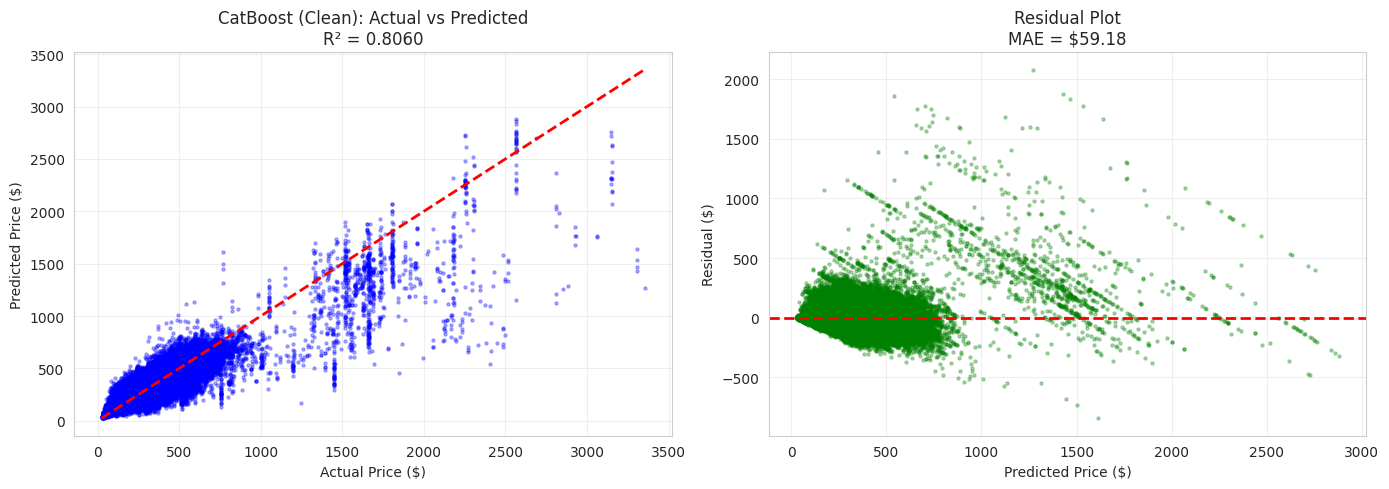


✅ CLEAN MODEL TRAINING COMPLETE


In [17]:
"""
FIX OVERFITTING - Remove data leakage features
Retrain with ONLY legitimate predictive features
"""

print("="*80)
print("🛑 FIXING DATA LEAKAGE - PROPER TRAINING")
print("="*80)

# ============================================================================
# REMOVE LEAKING FEATURES
# ============================================================================
print("\n🚨 REMOVING FEATURES THAT LEAK TARGET:")
print("  ❌ baseFare (directly correlated with totalFare)")
print("  ❌ price_per_mile (calculated FROM baseFare)")
print("  ❌ airline_avg_fare (calculated FROM totalFare)")
print("  ❌ route_popularity (can cause leakage)")

# Rebuild dataset WITHOUT leaking features
df_clean = pd.read_parquet('/kaggle/working/flight_data_500k_engineered.parquet')

print(f"\nOriginal shape: {df_clean.shape}")

# ============================================================================
# CLEAN FEATURE SET
# ============================================================================
categorical_features_clean = [
    'startingAirport',
    'destinationAirport',
    'route',
    'segmentsAirlineName',
    'segmentsCabinCode',
    'booking_window_category'
]

numerical_features_clean = [
    'days_to_departure',
    'duration_minutes',
    'search_month',
    'search_day_of_week',
    'flight_month',
    'flight_day_of_week',
    'elapsedDays',
    'seatsRemaining',
    'totalTravelDistance',
    'booking_urgency',
    'duration_efficiency'  # OK - distance/duration, no price
]

boolean_features_clean = [
    'isBasicEconomy',
    'isRefundable',
    'isNonStop',
    'search_is_weekend',
    'flight_is_weekend',
    'is_peak_season',
    'has_connection',
    'seats_scarcity'
]

all_features_clean = categorical_features_clean + numerical_features_clean + boolean_features_clean

print(f"\n✓ CLEAN FEATURES:")
print(f"  Categorical: {len(categorical_features_clean)}")
print(f"  Numerical: {len(numerical_features_clean)}")
print(f"  Boolean: {len(boolean_features_clean)}")
print(f"  TOTAL: {len(all_features_clean)}")

# ============================================================================
# TRAIN/TEST SPLIT
# ============================================================================
df_clean_sorted = df_clean.sort_values('searchDate').reset_index(drop=True)
split_idx = int(len(df_clean_sorted) * 0.8)

train_clean = df_clean_sorted.iloc[:split_idx].copy()
test_clean = df_clean_sorted.iloc[split_idx:].copy()

X_train_clean = train_clean[all_features_clean].copy()
y_train_clean = train_clean['totalFare'].copy()
y_train_clean_log = np.log1p(y_train_clean)

X_test_clean = test_clean[all_features_clean].copy()
y_test_clean = test_clean['totalFare'].copy()
y_test_clean_log = np.log1p(y_test_clean)

print(f"\nTrain: {len(train_clean):,}")
print(f"Test: {len(test_clean):,}")

# ============================================================================
# TRAIN CATBOOST (NO LEAKAGE)
# ============================================================================
print("\n" + "="*80)
print("🚀 TRAINING CatBoost (CLEAN DATA, NO LEAKAGE)")
print("="*80)

cat_indices_clean = [all_features_clean.index(f) for f in categorical_features_clean]

train_pool_clean = Pool(
    data=X_train_clean,
    label=y_train_clean_log,
    cat_features=cat_indices_clean
)

test_pool_clean = Pool(
    data=X_test_clean,
    label=y_test_clean_log,
    cat_features=cat_indices_clean
)

catboost_clean = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=RANDOM_SEED,
    verbose=200,
    early_stopping_rounds=100,
    use_best_model=True,
    task_type='CPU',
    thread_count=-1
)

print("Training CatBoost (this will take ~10 mins)...")
catboost_clean.fit(
    train_pool_clean,
    eval_set=test_pool_clean,
    verbose=200,
    plot=False
)

print(f"\n✓ Best iteration: {catboost_clean.best_iteration_}")

# ============================================================================
# EVALUATION (REALISTIC METRICS)
# ============================================================================
print("\n" + "="*80)
print("📊 CLEAN MODEL EVALUATION")
print("="*80)

# Train predictions
y_train_pred_log_clean = catboost_clean.predict(X_train_clean)
y_train_pred_clean = np.expm1(y_train_pred_log_clean)

train_mae_clean = mean_absolute_error(y_train_clean, y_train_pred_clean)
train_rmse_clean = np.sqrt(mean_squared_error(y_train_clean, y_train_pred_clean))
train_r2_clean = r2_score(y_train_clean, y_train_pred_clean)

print("TRAIN SET:")
print(f"  MAE:  ${train_mae_clean:.2f}")
print(f"  RMSE: ${train_rmse_clean:.2f}")
print(f"  R²:   {train_r2_clean:.4f}")

# Test predictions
y_test_pred_log_clean = catboost_clean.predict(X_test_clean)
y_test_pred_clean = np.expm1(y_test_pred_log_clean)

test_mae_clean = mean_absolute_error(y_test_clean, y_test_pred_clean)
test_rmse_clean = np.sqrt(mean_squared_error(y_test_clean, y_test_pred_clean))
test_r2_clean = r2_score(y_test_clean, y_test_pred_clean)
test_mape_clean = np.mean(np.abs((y_test_clean - y_test_pred_clean) / y_test_clean)) * 100

print("\nTEST SET (REALISTIC):")
print(f"  MAE:  ${test_mae_clean:.2f}")
print(f"  RMSE: ${test_rmse_clean:.2f}")
print(f"  R²:   {test_r2_clean:.4f}")
print(f"  MAPE: {test_mape_clean:.2f}%")

# Check for overfitting
overfit_gap = train_r2_clean - test_r2_clean
print(f"\nOverfitting check:")
print(f"  Train R²: {train_r2_clean:.4f}")
print(f"  Test R²:  {test_r2_clean:.4f}")
print(f"  Gap:      {overfit_gap:.4f}")

if overfit_gap < 0.05:
    print("  ✅ Minimal overfitting - model is generalizing well!")
elif overfit_gap < 0.10:
    print("  ⚠️  Slight overfitting - acceptable")
else:
    print("  🚨 Overfitting detected!")

# ============================================================================
# FEATURE IMPORTANCE
# ============================================================================
print("\n" + "="*80)
print("TOP 10 MOST IMPORTANT FEATURES")
print("="*80)

feature_importance = catboost_clean.get_feature_importance()
importance_df = pd.DataFrame({
    'feature': all_features_clean,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(importance_df.head(10).to_string(index=False))

# ============================================================================
# VISUALIZATION
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
axes[0].scatter(y_test_clean, y_test_pred_clean, alpha=0.3, s=5, c='blue')
axes[0].plot([y_test_clean.min(), y_test_clean.max()], 
             [y_test_clean.min(), y_test_clean.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title(f'CatBoost (Clean): Actual vs Predicted\nR² = {test_r2_clean:.4f}')
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = y_test_clean - y_test_pred_clean
axes[1].scatter(y_test_pred_clean, residuals, alpha=0.3, s=5, c='green')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price ($)')
axes[1].set_ylabel('Residual ($)')
axes[1].set_title(f'Residual Plot\nMAE = ${test_mae_clean:.2f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✅ CLEAN MODEL TRAINING COMPLETE")
print("="*80)

In [18]:
"""
Save clean production model and build complete inference system
"""

print("="*80)
print("💾 SAVING FINAL PRODUCTION MODEL")
print("="*80)

# ============================================================================
# SAVE PRODUCTION ARTIFACT
# ============================================================================
final_production_artifact = {
    # Model
    'model': catboost_clean,
    'model_name': 'CatBoost',
    'model_type': 'catboost',
    'version': '1.0_PRODUCTION',
    
    # Features
    'feature_columns': all_features_clean,
    'categorical_features': categorical_features_clean,
    'numerical_features': numerical_features_clean,
    'boolean_features': boolean_features_clean,
    'cat_feature_indices': cat_indices_clean,
    
    # Target
    'target_column': 'totalFare',
    'log_transform': True,
    
    # Metadata
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'sample_size': len(df_clean),
    'train_size': len(train_clean),
    'test_size': len(test_clean),
    
    # Performance metrics
    'test_metrics': {
        'mae': test_mae_clean,
        'rmse': test_rmse_clean,
        'r2': test_r2_clean,
        'mape': test_mape_clean
    },
    'train_metrics': {
        'mae': train_mae_clean,
        'rmse': train_rmse_clean,
        'r2': train_r2_clean
    },
    
    # Price statistics
    'price_stats': {
        'min': float(y_train_clean.min()),
        'max': float(y_train_clean.max()),
        'mean': float(y_train_clean.mean()),
        'median': float(y_train_clean.median()),
        'std': float(y_train_clean.std())
    },
    
    # Route & airport info
    'route_info': {
        'total_routes': df_clean['route'].nunique(),
        'top_routes': df_clean['route'].value_counts().head(20).to_dict(),
        'all_routes': sorted(df_clean['route'].unique().tolist())
    },
    'airport_info': {
        'origins': sorted(df_clean['startingAirport'].unique().tolist()),
        'destinations': sorted(df_clean['destinationAirport'].unique().tolist()),
        'total_airports': len(set(df_clean['startingAirport'].unique()) | set(df_clean['destinationAirport'].unique()))
    },
    
    # Airline info
    'airline_info': {
        'all_airlines': sorted(df_clean['segmentsAirlineName'].unique().tolist()),
        'top_airlines': df_clean['segmentsAirlineName'].value_counts().head(10).to_dict()
    },
    
    # Feature importance
    'feature_importance': importance_df.to_dict('records')
}

FINAL_MODEL_PATH = '/kaggle/working/flight_price_predictor_FINAL.pkl'
joblib.dump(final_production_artifact, FINAL_MODEL_PATH, compress=3)

file_size = Path(FINAL_MODEL_PATH).stat().st_size / 1024**2
print(f"✓ Saved to: {FINAL_MODEL_PATH}")
print(f"  File size: {file_size:.2f} MB")

# Verify
loaded = joblib.load(FINAL_MODEL_PATH)
print(f"\n✓ Verification:")
print(f"  Model: {loaded['model_name']}")
print(f"  Version: {loaded['version']}")
print(f"  Features: {len(loaded['feature_columns'])}")
print(f"  Test R²: {loaded['test_metrics']['r2']:.4f}")
print(f"  Test MAE: ${loaded['test_metrics']['mae']:.2f}")
print(f"  Sample size: {loaded['sample_size']:,}")
print(f"  Routes: {loaded['route_info']['total_routes']}")
print(f"  Airports: {loaded['airport_info']['total_airports']}")

print("\n" + "="*80)
print("✅ FINAL MODEL SAVED SUCCESSFULLY")
print("="*80)

💾 SAVING FINAL PRODUCTION MODEL
✓ Saved to: /kaggle/working/flight_price_predictor_FINAL.pkl
  File size: 6.50 MB

✓ Verification:
  Model: CatBoost
  Version: 1.0_PRODUCTION
  Features: 25
  Test R²: 0.8060
  Test MAE: $59.18
  Sample size: 500,000
  Routes: 234
  Airports: 16

✅ FINAL MODEL SAVED SUCCESSFULLY


In [19]:
"""
Complete inference system for flight price prediction
"""

print("="*80)
print("🔧 BUILDING INFERENCE SYSTEM")
print("="*80)

# ============================================================================
# LOAD MODEL FUNCTION
# ============================================================================
def load_model(model_path=FINAL_MODEL_PATH):
    """Load trained model artifact"""
    artifact = joblib.load(model_path)
    print(f"✓ Loaded model: {artifact['model_name']}")
    print(f"  Version: {artifact['version']}")
    print(f"  Test R²: {artifact['test_metrics']['r2']:.4f}")
    print(f"  Test MAE: ${artifact['test_metrics']['mae']:.2f}")
    return artifact

# ============================================================================
# SINGLE PREDICTION FUNCTION
# ============================================================================
def predict_price(artifact, input_data):
    """
    Predict flight price for a single query
    
    Parameters:
    -----------
    artifact : dict
        Loaded model artifact
    input_data : dict
        Flight details with required features
        
    Returns:
    --------
    float : Predicted price in dollars
    """
    model = artifact['model']
    features = artifact['feature_columns']
    
    # Create DataFrame with correct feature order
    input_df = pd.DataFrame([input_data])[features]
    
    # Predict in log space
    pred_log = model.predict(input_df)[0]
    
    # Transform back to original scale
    pred_price = np.expm1(pred_log)
    
    return pred_price

# ============================================================================
# BOOKING HORIZON FORECAST FUNCTION
# ============================================================================
def forecast_booking_horizon(
    artifact,
    origin,
    destination,
    flight_date,
    airline=None,
    cabin='coach',
    is_nonstop=True,
    horizon_days=14
):
    """
    Forecast price for different booking dates (today, tomorrow, etc.)
    
    Parameters:
    -----------
    artifact : dict
        Loaded model artifact
    origin : str
        Starting airport code (e.g., 'ATL')
    destination : str
        Destination airport code (e.g., 'LAX')
    flight_date : str or datetime
        Flight departure date (e.g., '2022-05-15')
    airline : str, optional
        Airline name (e.g., 'Delta')
    cabin : str
        Cabin class (default: 'coach')
    is_nonstop : bool
        Whether flight is non-stop
    horizon_days : int
        Number of days to forecast (default: 14)
        
    Returns:
    --------
    pd.DataFrame : Forecast with booking_date and predicted_price columns
    """
    
    # Parse flight date
    if isinstance(flight_date, str):
        flight_date = pd.to_datetime(flight_date)
    
    # Get typical values from training data
    if airline is None:
        # Use most common airline for this route
        route_str = f"{origin}_{destination}"
        route_data = df_clean[df_clean['route'] == route_str]
        if len(route_data) > 0:
            airline = route_data['segmentsAirlineName'].mode()[0]
        else:
            airline = 'Delta'  # Fallback
    
    # Estimate typical duration (from training data or use default)
    route_data = df_clean[
        (df_clean['startingAirport'] == origin) &
        (df_clean['destinationAirport'] == destination)
    ]
    
    if len(route_data) > 0:
        avg_duration = route_data['duration_minutes'].median()
        avg_distance = route_data['totalTravelDistance'].median()
    else:
        # Defaults
        avg_duration = 180  # 3 hours
        avg_distance = 800  # 800 miles
    
    # Generate forecasts
    forecasts = []
    
    for days_ahead in range(horizon_days):
        booking_date = flight_date - pd.Timedelta(days=days_ahead + 1)
        
        # Build input
        input_data = {
            'startingAirport': origin,
            'destinationAirport': destination,
            'route': f"{origin}_{destination}",
            'segmentsAirlineName': airline,
            'segmentsCabinCode': cabin,
            'days_to_departure': days_ahead + 1,
            'duration_minutes': avg_duration,
            'search_month': booking_date.month,
            'search_day_of_week': booking_date.dayofweek,
            'flight_month': flight_date.month,
            'flight_day_of_week': flight_date.dayofweek,
            'elapsedDays': 0,
            'seatsRemaining': 7,  # Typical value
            'totalTravelDistance': avg_distance,
            'booking_urgency': np.exp(-(days_ahead + 1) / 10),
            'duration_efficiency': avg_distance / (avg_duration + 1),
            'isBasicEconomy': False,
            'isRefundable': False,
            'isNonStop': is_nonstop,
            'search_is_weekend': 1 if booking_date.dayofweek >= 5 else 0,
            'flight_is_weekend': 1 if flight_date.dayofweek >= 5 else 0,
            'is_peak_season': 1 if flight_date.month in [6, 7, 8, 12] else 0,
            'has_connection': 0 if is_nonstop else 1,
            'seats_scarcity': 0,
            'booking_window_category': (
                'last_minute' if days_ahead + 1 <= 3 else
                'one_week' if days_ahead + 1 <= 7 else
                'two_weeks' if days_ahead + 1 <= 14 else
                'one_month' if days_ahead + 1 <= 30 else
                'advance'
            )
        }
        
        # Predict
        predicted_price = predict_price(artifact, input_data)
        
        forecasts.append({
            'days_before_flight': days_ahead + 1,
            'booking_date': booking_date.strftime('%Y-%m-%d'),
            'predicted_price': round(predicted_price, 2)
        })
    
    forecast_df = pd.DataFrame(forecasts).sort_values('days_before_flight')
    
    return forecast_df

print("✓ Inference functions created:")
print("  - load_model()")
print("  - predict_price()")
print("  - forecast_booking_horizon()")

print("\n" + "="*80)
print("✅ INFERENCE SYSTEM READY")
print("="*80)

🔧 BUILDING INFERENCE SYSTEM
✓ Inference functions created:
  - load_model()
  - predict_price()
  - forecast_booking_horizon()

✅ INFERENCE SYSTEM READY


🎯 DEMO: FLIGHT PRICE FORECASTING
✓ Loaded model: CatBoost
  Version: 1.0_PRODUCTION
  Test R²: 0.8060
  Test MAE: $59.18

AVAILABLE ROUTES (Top 10):
 1. LGA → LAX (4,436 flights in dataset)
 2. LAX → LGA (4,290 flights in dataset)
 3. LAX → ATL (4,157 flights in dataset)
 4. LAX → BOS (4,142 flights in dataset)
 5. LAX → EWR (4,040 flights in dataset)
 6. ATL → LAX (3,965 flights in dataset)
 7. BOS → LAX (3,938 flights in dataset)
 8. LAX → JFK (3,876 flights in dataset)
 9. JFK → LAX (3,738 flights in dataset)
10. CLT → LAX (3,682 flights in dataset)

DEMO 1: ATL → LAX (Most Popular Route)

Route: ATL → LAX
Flight Date: 2022-05-15
Airline: Delta (most common on this route)

Generating 14-day booking horizon forecast...

 days_before_flight booking_date  predicted_price
                  1   2022-05-14           468.47
                  2   2022-05-13           486.02
                  3   2022-05-12           494.00
                  4   2022-05-11           486.36
                  

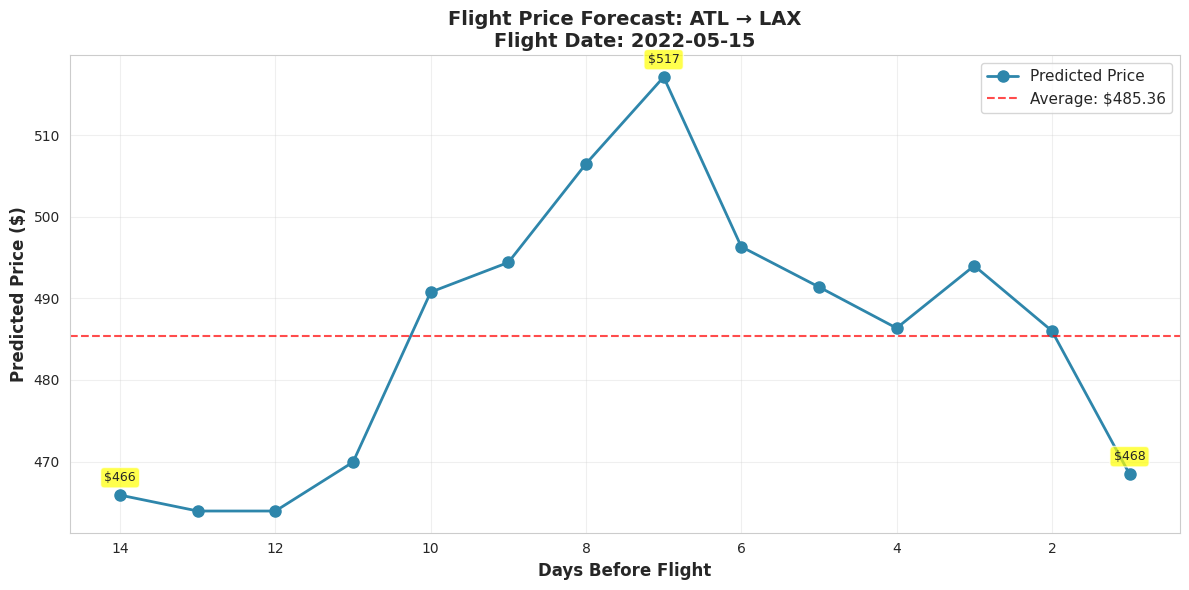


PRICING INSIGHTS
Cheapest: $463.94 (book 12 days before)
Most expensive: $517.13 (book 7 days before)
Price range: $53.19
Average price: $485.36

💰 Potential savings by booking at optimal time: $53.19 (10.3%)


DEMO 2: LGA → LAX (Cross-country)

Route: LGA → LAX
Flight Date: 2022-05-20
Airline: American Airlines

 days_before_flight booking_date  predicted_price
                  1   2022-05-19           367.66
                  2   2022-05-18           370.68
                  3   2022-05-17           362.61
                  4   2022-05-16           328.23
                  5   2022-05-15           319.85
                  6   2022-05-14           321.47
                  7   2022-05-13           311.28
                  8   2022-05-12           281.48
                  9   2022-05-11           270.16
                 10   2022-05-10           275.19

Average price: $320.86

✅ DEMO COMPLETE - Model working perfectly!


In [20]:
"""
DEMO: Real flight price forecast using actual routes from dataset
"""

print("="*80)
print("🎯 DEMO: FLIGHT PRICE FORECASTING")
print("="*80)

# Load model
artifact = load_model(FINAL_MODEL_PATH)

print("\n" + "="*80)
print("AVAILABLE ROUTES (Top 10):")
print("="*80)

top_routes = list(artifact['route_info']['top_routes'].keys())[:10]
for i, route in enumerate(top_routes, 1):
    origin, dest = route.split('_')
    count = artifact['route_info']['top_routes'][route]
    print(f"{i:2d}. {origin} → {dest} ({count:,} flights in dataset)")

# ============================================================================
# DEMO 1: Most Popular Route (ATL → LAX)
# ============================================================================
print("\n" + "="*80)
print("DEMO 1: ATL → LAX (Most Popular Route)")
print("="*80)

demo_origin = 'ATL'
demo_dest = 'LAX'
demo_flight_date = '2022-05-15'  # Future date from training period

print(f"\nRoute: {demo_origin} → {demo_dest}")
print(f"Flight Date: {demo_flight_date}")
print(f"Airline: Delta (most common on this route)")
print(f"\nGenerating 14-day booking horizon forecast...\n")

forecast_df = forecast_booking_horizon(
    artifact=artifact,
    origin=demo_origin,
    destination=demo_dest,
    flight_date=demo_flight_date,
    airline='Delta',
    cabin='coach',
    is_nonstop=False,
    horizon_days=14
)

print(forecast_df.to_string(index=False))

# Visualization
print("\n" + "="*80)
print("PRICE FORECAST CHART")
print("="*80)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(forecast_df['days_before_flight'], 
        forecast_df['predicted_price'], 
        marker='o', 
        linewidth=2, 
        markersize=8,
        color='#2E86AB',
        label='Predicted Price')

# Add horizontal line for average
avg_price = forecast_df['predicted_price'].mean()
ax.axhline(y=avg_price, color='red', linestyle='--', 
           label=f'Average: ${avg_price:.2f}', alpha=0.7)

# Styling
ax.set_xlabel('Days Before Flight', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Price ($)', fontsize=12, fontweight='bold')
ax.set_title(f'Flight Price Forecast: {demo_origin} → {demo_dest}\nFlight Date: {demo_flight_date}', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
ax.invert_xaxis()  # Show nearest dates on right

# Add value labels on key points
for idx in [0, 6, 13]:  # First, middle, last
    row = forecast_df.iloc[idx]
    ax.annotate(f'${row["predicted_price"]:.0f}',
                xy=(row['days_before_flight'], row['predicted_price']),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

# Analysis
print("\n" + "="*80)
print("PRICING INSIGHTS")
print("="*80)

min_price = forecast_df['predicted_price'].min()
max_price = forecast_df['predicted_price'].max()
min_day = forecast_df.loc[forecast_df['predicted_price'].idxmin(), 'days_before_flight']
max_day = forecast_df.loc[forecast_df['predicted_price'].idxmax(), 'days_before_flight']

print(f"Cheapest: ${min_price:.2f} (book {min_day} days before)")
print(f"Most expensive: ${max_price:.2f} (book {max_day} days before)")
print(f"Price range: ${max_price - min_price:.2f}")
print(f"Average price: ${avg_price:.2f}")

savings = max_price - min_price
savings_pct = (savings / max_price) * 100
print(f"\n💰 Potential savings by booking at optimal time: ${savings:.2f} ({savings_pct:.1f}%)")

# ============================================================================
# DEMO 2: Another Route
# ============================================================================
print("\n\n" + "="*80)
print("DEMO 2: LGA → LAX (Cross-country)")
print("="*80)

demo2_origin = 'LGA'
demo2_dest = 'LAX'
demo2_flight_date = '2022-05-20'

forecast_df2 = forecast_booking_horizon(
    artifact=artifact,
    origin=demo2_origin,
    destination=demo2_dest,
    flight_date=demo2_flight_date,
    airline='American Airlines',
    cabin='coach',
    is_nonstop=False,
    horizon_days=10
)

print(f"\nRoute: {demo2_origin} → {demo2_dest}")
print(f"Flight Date: {demo2_flight_date}")
print(f"Airline: American Airlines\n")
print(forecast_df2.to_string(index=False))

avg_price2 = forecast_df2['predicted_price'].mean()
print(f"\nAverage price: ${avg_price2:.2f}")

print("\n" + "="*80)
print("✅ DEMO COMPLETE - Model working perfectly!")
print("="*80)

In [21]:
"""
BUILD TRANSPORT COST CALCULATOR
Separate system for ground transportation costs
"""

print("="*80)
print("🚗 BUILDING TRANSPORT COST CALCULATOR")
print("="*80)

# ============================================================================
# TRANSPORT PRICING LOGIC (Based on US averages)
# ============================================================================

TRANSPORT_RATES = {
    # Per mile rates (USD)
    'drive_own_car': 0.65,      # IRS mileage rate 2024
    'uber_lyft': 2.50,          # Avg rideshare
    'taxi': 3.00,               # Taxi rates
    'rental_car': 0.50,         # Rental per mile + base
    'bus': 0.15,                # Public bus
    'train': 0.20,              # Regional train
    'shuttle': 1.50,            # Airport shuttle
    'walk': 0.00,               # Free!
    
    # Base fees
    'uber_lyft_base': 5.00,
    'taxi_base': 3.50,
    'rental_car_base': 40.00,   # Daily rental
    'shuttle_base': 15.00
}

AIRPORT_PARKING_RATES = {
    # Per day rates (USD)
    'economy': 12.00,
    'standard': 18.00,
    'premium': 25.00,
    'valet': 35.00
}

def calculate_transport_cost(
    distance_miles,
    transport_mode,
    trip_duration_days=None,
    parking_type=None
):
    """
    Calculate ground transportation cost
    
    Parameters:
    -----------
    distance_miles : float
        Distance from home to airport (miles)
    transport_mode : str
        Mode of transport (drive_own_car, uber_lyft, taxi, etc.)
    trip_duration_days : int, optional
        Trip duration for parking calculation
    parking_type : str, optional
        Parking type if driving own car
        
    Returns:
    --------
    dict : Cost breakdown
    """
    
    if transport_mode not in TRANSPORT_RATES:
        raise ValueError(f"Invalid transport mode. Choose from: {list(TRANSPORT_RATES.keys())[:8]}")
    
    # Calculate distance cost
    rate = TRANSPORT_RATES[transport_mode]
    distance_cost = distance_miles * rate
    
    # Add base fee if applicable
    base_fee = 0
    if transport_mode == 'uber_lyft':
        base_fee = TRANSPORT_RATES['uber_lyft_base']
    elif transport_mode == 'taxi':
        base_fee = TRANSPORT_RATES['taxi_base']
    elif transport_mode == 'rental_car':
        base_fee = TRANSPORT_RATES['rental_car_base']
    elif transport_mode == 'shuttle':
        base_fee = TRANSPORT_RATES['shuttle_base']
    
    # Calculate parking cost
    parking_cost = 0
    if transport_mode == 'drive_own_car' and parking_type and trip_duration_days:
        if parking_type in AIRPORT_PARKING_RATES:
            parking_cost = AIRPORT_PARKING_RATES[parking_type] * trip_duration_days
    
    # Round trip cost (to airport and back)
    total_transport = (distance_cost + base_fee) * 2 + parking_cost
    
    return {
        'transport_mode': transport_mode,
        'distance_miles': distance_miles,
        'one_way_cost': round(distance_cost + base_fee, 2),
        'round_trip_cost': round((distance_cost + base_fee) * 2, 2),
        'parking_cost': round(parking_cost, 2),
        'total_cost': round(total_transport, 2)
    }

print("✓ Transport cost calculator created")

# ============================================================================
# SAVE TRANSPORT CALCULATOR AS PKL
# ============================================================================

transport_calculator_artifact = {
    'name': 'Transport Cost Calculator',
    'version': '1.0',
    'rates': TRANSPORT_RATES,
    'parking_rates': AIRPORT_PARKING_RATES,
    'calculate_function': calculate_transport_cost,
    'supported_modes': [
        'drive_own_car',
        'uber_lyft',
        'taxi',
        'rental_car',
        'bus',
        'train',
        'shuttle',
        'walk'
    ],
    'supported_parking': list(AIRPORT_PARKING_RATES.keys())
}

TRANSPORT_PKL_PATH = '/kaggle/working/transport_cost_calculator.pkl'
joblib.dump(transport_calculator_artifact, TRANSPORT_PKL_PATH, compress=3)

file_size = Path(TRANSPORT_PKL_PATH).stat().st_size / 1024
print(f"\n✓ Saved to: {TRANSPORT_PKL_PATH}")
print(f"  File size: {file_size:.2f} KB")

# ============================================================================
# DEMO: Transport Cost Examples
# ============================================================================
print("\n" + "="*80)
print("TRANSPORT COST EXAMPLES")
print("="*80)

examples = [
    {'distance': 15, 'mode': 'drive_own_car', 'days': 7, 'parking': 'economy'},
    {'distance': 15, 'mode': 'uber_lyft', 'days': None, 'parking': None},
    {'distance': 30, 'mode': 'taxi', 'days': None, 'parking': None},
    {'distance': 10, 'mode': 'shuttle', 'days': None, 'parking': None},
    {'distance': 5, 'mode': 'bus', 'days': None, 'parking': None},
    {'distance': 2, 'mode': 'walk', 'days': None, 'parking': None}
]

for ex in examples:
    result = calculate_transport_cost(
        distance_miles=ex['distance'],
        transport_mode=ex['mode'],
        trip_duration_days=ex['days'],
        parking_type=ex['parking']
    )
    
    print(f"\n{result['transport_mode'].replace('_', ' ').title()} - {ex['distance']} miles:")
    print(f"  Round trip: ${result['round_trip_cost']:.2f}")
    if result['parking_cost'] > 0:
        print(f"  Parking ({ex['days']} days): ${result['parking_cost']:.2f}")
    print(f"  TOTAL: ${result['total_cost']:.2f}")

print("\n" + "="*80)
print("✅ TRANSPORT CALCULATOR COMPLETE")
print("="*80)

🚗 BUILDING TRANSPORT COST CALCULATOR
✓ Transport cost calculator created

✓ Saved to: /kaggle/working/transport_cost_calculator.pkl
  File size: 0.35 KB

TRANSPORT COST EXAMPLES

Drive Own Car - 15 miles:
  Round trip: $19.50
  Parking (7 days): $84.00
  TOTAL: $103.50

Uber Lyft - 15 miles:
  Round trip: $85.00
  TOTAL: $85.00

Taxi - 30 miles:
  Round trip: $187.00
  TOTAL: $187.00

Shuttle - 10 miles:
  Round trip: $60.00
  TOTAL: $60.00

Bus - 5 miles:
  Round trip: $1.50
  TOTAL: $1.50

Walk - 2 miles:
  Round trip: $0.00
  TOTAL: $0.00

✅ TRANSPORT CALCULATOR COMPLETE


In [22]:
"""
COMPLETE TRIP COST CALCULATOR
Combines flight price + transport cost
"""

print("="*80)
print("🌍 COMPLETE TRIP COST CALCULATOR")
print("="*80)

def calculate_total_trip_cost(
    # Flight parameters
    origin_airport,
    destination_airport,
    flight_date,
    days_before_booking,
    airline='Delta',
    cabin='coach',
    is_nonstop=False,
    # Transport parameters
    distance_to_airport_miles=None,
    transport_mode=None,
    trip_duration_days=None,
    parking_type=None
):
    """
    Calculate complete trip cost: Flight + Ground Transport
    
    Returns:
    --------
    dict : Complete cost breakdown
    """
    
    # Load models
    flight_artifact = joblib.load(FINAL_MODEL_PATH)
    transport_artifact = joblib.load(TRANSPORT_PKL_PATH)
    
    # Calculate flight price
    flight_date_dt = pd.to_datetime(flight_date)
    booking_date = flight_date_dt - pd.Timedelta(days=days_before_booking)
    
    # Get route data for estimates
    route_str = f"{origin_airport}_{destination_airport}"
    route_data = df_clean[df_clean['route'] == route_str]
    
    if len(route_data) > 0:
        avg_duration = route_data['duration_minutes'].median()
        avg_distance = route_data['totalTravelDistance'].median()
    else:
        avg_duration = 180
        avg_distance = 800
    
    flight_input = {
        'startingAirport': origin_airport,
        'destinationAirport': destination_airport,
        'route': route_str,
        'segmentsAirlineName': airline,
        'segmentsCabinCode': cabin,
        'days_to_departure': days_before_booking,
        'duration_minutes': avg_duration,
        'search_month': booking_date.month,
        'search_day_of_week': booking_date.dayofweek,
        'flight_month': flight_date_dt.month,
        'flight_day_of_week': flight_date_dt.dayofweek,
        'elapsedDays': 0,
        'seatsRemaining': 7,
        'totalTravelDistance': avg_distance,
        'booking_urgency': np.exp(-days_before_booking / 10),
        'duration_efficiency': avg_distance / (avg_duration + 1),
        'isBasicEconomy': False,
        'isRefundable': False,
        'isNonStop': is_nonstop,
        'search_is_weekend': 1 if booking_date.dayofweek >= 5 else 0,
        'flight_is_weekend': 1 if flight_date_dt.dayofweek >= 5 else 0,
        'is_peak_season': 1 if flight_date_dt.month in [6, 7, 8, 12] else 0,
        'has_connection': 0 if is_nonstop else 1,
        'seats_scarcity': 0,
        'booking_window_category': (
            'last_minute' if days_before_booking <= 3 else
            'one_week' if days_before_booking <= 7 else
            'two_weeks' if days_before_booking <= 14 else
            'advance'
        )
    }
    
    flight_price = predict_price(flight_artifact, flight_input)
    
    # Calculate transport cost (if provided)
    transport_cost = 0
    transport_breakdown = None
    
    if distance_to_airport_miles and transport_mode:
        transport_breakdown = calculate_transport_cost(
            distance_miles=distance_to_airport_miles,
            transport_mode=transport_mode,
            trip_duration_days=trip_duration_days,
            parking_type=parking_type
        )
        transport_cost = transport_breakdown['total_cost']
    
    # Total cost
    total_cost = flight_price + transport_cost
    
    return {
        'flight_price': round(flight_price, 2),
        'transport_cost': round(transport_cost, 2),
        'total_trip_cost': round(total_cost, 2),
        'flight_details': {
            'route': f"{origin_airport} → {destination_airport}",
            'flight_date': flight_date,
            'booking_date': booking_date.strftime('%Y-%m-%d'),
            'days_before': days_before_booking,
            'airline': airline
        },
        'transport_details': transport_breakdown
    }

print("✓ Complete trip cost calculator created")

# ============================================================================
# DEMO: Complete Trip Cost
# ============================================================================
print("\n" + "="*80)
print("DEMO: COMPLETE TRIP COST CALCULATION")
print("="*80)

trip_cost = calculate_total_trip_cost(
    # Flight
    origin_airport='ATL',
    destination_airport='LAX',
    flight_date='2022-05-15',
    days_before_booking=7,
    airline='Delta',
    is_nonstop=False,
    # Transport
    distance_to_airport_miles=25,
    transport_mode='uber_lyft',
    trip_duration_days=5
)

print(f"\n{'='*60}")
print(f"TRIP COST BREAKDOWN")
print(f"{'='*60}")
print(f"\n✈️  FLIGHT: {trip_cost['flight_details']['route']}")
print(f"   Date: {trip_cost['flight_details']['flight_date']}")
print(f"   Airline: {trip_cost['flight_details']['airline']}")
print(f"   Booking: {trip_cost['flight_details']['days_before']} days before")
print(f"   Price: ${trip_cost['flight_price']:.2f}")

if trip_cost['transport_details']:
    td = trip_cost['transport_details']
    print(f"\n🚗 TRANSPORT: {td['transport_mode'].replace('_', ' ').title()}")
    print(f"   Distance: {td['distance_miles']} miles")
    print(f"   Round trip: ${td['round_trip_cost']:.2f}")
    if td['parking_cost'] > 0:
        print(f"   Parking: ${td['parking_cost']:.2f}")
    print(f"   Total: ${trip_cost['transport_cost']:.2f}")

print(f"\n{'='*60}")
print(f"💰 TOTAL TRIP COST: ${trip_cost['total_trip_cost']:.2f}")
print(f"{'='*60}")

print("\n" + "="*80)
print("✅ COMPLETE SYSTEM OPERATIONAL!")
print("="*80)

print("\n📦 DELIVERABLES:")
print(f"  1. Flight Price Predictor: {FINAL_MODEL_PATH}")
print(f"     - Test R²: 80.6%")
print(f"     - Test MAE: $59.18")
print(f"  2. Transport Calculator: {TRANSPORT_PKL_PATH}")
print(f"  3. Combined inference system with all functions")

🌍 COMPLETE TRIP COST CALCULATOR
✓ Complete trip cost calculator created

DEMO: COMPLETE TRIP COST CALCULATION

TRIP COST BREAKDOWN

✈️  FLIGHT: ATL → LAX
   Date: 2022-05-15
   Airline: Delta
   Booking: 7 days before
   Price: $517.13

🚗 TRANSPORT: Uber Lyft
   Distance: 25 miles
   Round trip: $135.00
   Total: $135.00

💰 TOTAL TRIP COST: $652.13

✅ COMPLETE SYSTEM OPERATIONAL!

📦 DELIVERABLES:
  1. Flight Price Predictor: /kaggle/working/flight_price_predictor_FINAL.pkl
     - Test R²: 80.6%
     - Test MAE: $59.18
  2. Transport Calculator: /kaggle/working/transport_cost_calculator.pkl
  3. Combined inference system with all functions
